dotplot or heatmap for fig 2D to show genes linked to hair follicle development

# Import and settings

In [1]:
%load_ext autoreload
%autoreload 2

import os, re, gc, joblib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import rcParams
from matplotlib.colors import ListedColormap
import seaborn as sn
import plotnine as pln
import anndata
import scanpy as sc
import scvelo as scv
import sctk as sk
import cellrank as cr

rcParams["pdf.fonttype"] = 42
rcParams["ps.fonttype"] = 42
expr_cmap = sk.expression_colormap()
np.set_printoptions(linewidth=150)

import numpy_groupies as npg
from sklearn.preprocessing import minmax_scale
import plotnine as pln
from plotnine import ggplot, aes

# Load data

In [2]:
fetal_h5ad = "../20210611_final_object/fetal_skin.norm.maternal_removed.20220202.h5ad"

In [3]:
pooled_kc_h5ad = "../20200626_make_figure_for_Muzz/pooled_keratinocytes.processed.cellxgene.h5ad"

In [4]:
color_codes = {
    "POSTN+ basal": "#7C4F9A",
    "Basal": "#D72029",
    "Matrix/placode": "#CEB08D",
    "Cuticle/cortex": "#8C584C",
    "Inner root sheath": "#7E7E7F",
    "Outer root sheath": "#D179AF",
    "Companion layer": "#BABC26",
    "Immature basal": "#EF7E1F",
    "Immature suprabasal": "#2BA137",
    "Periderm": "#1977B6",
    "Suprabasal IFE": "#26B8CA",
}

In [5]:
fetal_ad0 = sc.read(fetal_h5ad)

Only considering the two last: ['.20220202', '.h5ad'].
Only considering the two last: ['.20220202', '.h5ad'].


In [6]:
fetal_ad0.obs.loc[
    fetal_ad0.obs.independent_annotation_broad5 == "Epithelium", "joint_annotation_20220202"
].value_counts().where(lambda x: x > 0).dropna()

Basal                  815.0
Melanocyte             604.0
Matrix/placode         254.0
Melanoblast            190.0
Periderm               153.0
Immature basal          65.0
POSTN+ basal            46.0
Suprabasal IFE          30.0
Companion layer         27.0
Outer root sheath       25.0
Cuticle/cortex          21.0
Inner root sheath       18.0
Immature suprabasal     15.0
Name: joint_annotation_20220202, dtype: float64

In [7]:
KC_ad0 = fetal_ad0[
    fetal_ad0.obs.joint_annotation.isin(
        [
            "Periderm",
            "Immature basal",
            "Immature suprabasal",
            "Basal",
            "Basal POSTN+",
            "Basal SHH+",
            "Cuticle/cortex",
            "Outer root sheath",
            "Inner root sheath",
            "Companion layer",
        ]
    )
].copy()

In [8]:
KC_ad0

AnnData object with n_obs × n_vars = 1439 × 28885
    obs: 'sanger_id', 'chemistry', 'donor', 'gender', 'pcw', 'sorting', 'sample', 'chemistry_sorting', 'cell_caller', 'scrublet_score', 'cluster_scrublet_score', 'doublet_pval', 'bh_doublet_pval', 'n_counts', 'n_genes', 'percent_mito', 'percent_ribo', 'percent_hb', 'independent_annotation_refined', 'independent_annotation_broad1', 'independent_annotation_broad2', 'independent_annotation_broad3', 'independent_annotation_broad4', 'independent_annotation_broad5', 'joint_annotation', 'is_maternal', 'fig1b_annotation', 'independent_annotation_refined_20220201a', 'independent_annotation_refined_20220201b', 'independent_annotation_broad1_20220201', 'independent_annotation_broad2_20220201', 'independent_annotation_broad3_20220201', 'joint_annotation_20220201a', 'joint_annotation_20220201b', 'fig1b_annotation_20220201', 'joint_annotation_20220202', 'independent_annotation_refined_20220202', 'fig1b_annotation_20220202'
    var: 'gene_ids', 'mito'

In [9]:
pooled_KC_ad0 = sc.read(pooled_kc_h5ad)

Only considering the two last: ['.cellxgene', '.h5ad'].
Only considering the two last: ['.cellxgene', '.h5ad'].


In [10]:
pooled_KC_ad0

AnnData object with n_obs × n_vars = 3776 × 15277
    obs: 'batch', 'chemistry_sorting', 'dataset', 'day', 'donor', 'gender', 'n_counts', 'n_genes', 'nh3_annot1', 'percent_hb', 'percent_mito', 'percent_ribo', 'percent_top50', 'sample_id', 'strain', 'week', 'annot', 'joint_annot'
    var: 'gene_ids'
    obsm: 'X_umap_hm'

In [12]:
pooled_KC_ad0.obs.dataset.value_counts()

organoid      2324
fetal_skin    1452
Name: dataset, dtype: int64

In [11]:
pooled_KC_ad0.obs.joint_annot.cat.categories

Index(['Periderm', 'Immature basal', 'Immature suprabasal', 'Basal',
       'Basal POSTN+', 'Basal SHH+', 'Cuticle/cortex', 'Outer root sheath',
       'Inner root sheath', 'Companion layer', 'Suprabasal IFE'],
      dtype='object')

In [14]:
fetal_ad0.obs.loc[
    fetal_ad0.obs.independent_annotation_broad5 == "Epithelium", "joint_annotation_20220202"
].value_counts().where(lambda x: x > 0).dropna().index

CategoricalIndex(['Basal', 'Melanocyte', 'Matrix/placode', 'Melanoblast',
                  'Periderm', 'Immature basal', 'POSTN+ basal',
                  'Suprabasal IFE', 'Companion layer', 'Outer root sheath',
                  'Cuticle/cortex', 'Inner root sheath',
                  'Immature suprabasal'],
                 categories=['ASDC', 'Iron-recycling macrophage', 'Adipocytes', 'Arterial', 'B cell', 'Basal', 'POSTN+ basal', 'CD4 T cell', ...], ordered=False, dtype='category')

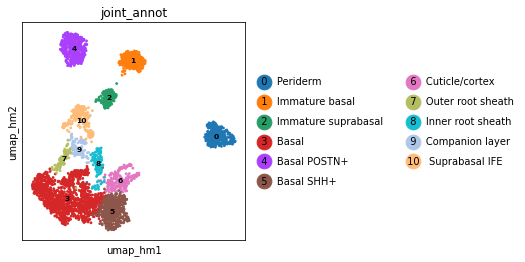

In [5]:
sk.plot_embedding(pooled_KC_ad0, basis="umap_hm", groupby="joint_annot");

In [11]:
pooled_KC_ad0.obs["joint_annot2"] = sk.regroup(
    pooled_KC_ad0,
    groupby="joint_annot",
    regroups={"Matrix/placode": "Basal SHH+", "POSTN+ basal": "Basal POSTN+"},
)

In [12]:
pooled_KC_ad0.obs.joint_annot2.cat.categories

Index(['Basal', 'Companion layer', 'Cuticle/cortex', 'Immature basal',
       'Immature suprabasal', 'Inner root sheath', 'Matrix/placode',
       'Outer root sheath', 'POSTN+ basal', 'Periderm', 'Suprabasal IFE'],
      dtype='object')

In [13]:
pooled_KC_ad0.obs.joint_annot2.cat.reorder_categories(
    [
        "Periderm",
        "Immature basal",
        "Immature suprabasal",
        "Basal",
        "POSTN+ basal",
        "Matrix/placode",
        "Cuticle/cortex",
        "Outer root sheath",
        "Inner root sheath",
        "Companion layer",
        "Suprabasal IFE",
    ],
    inplace=True,
)

In [14]:
sk.clear_colors(pooled_KC_ad0)

In [15]:
pooled_KC_ad0.uns["joint_annot2_colors"] = [
    color_codes[ct] for ct in pooled_KC_ad0.obs.joint_annot2.cat.categories
]

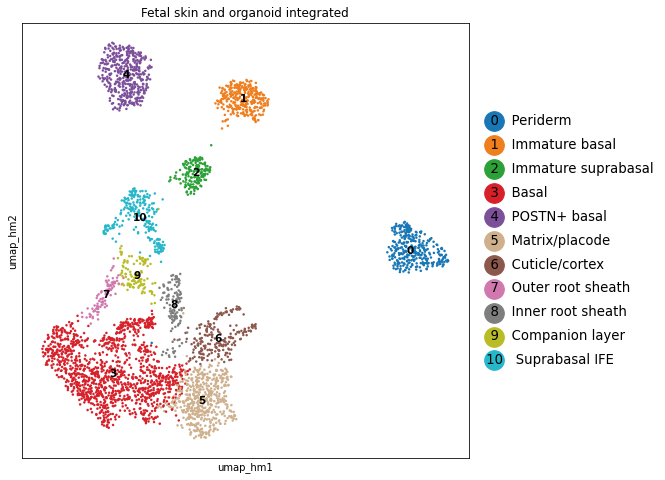

In [48]:
sk.plot_embedding(
    pooled_KC_ad0,
    basis="umap_hm",
    groupby="joint_annot2",
    size=25,
    figsize=(8, 8),
    save="Pooled_KC.joint_annotation.pdf",
    legend_fontsize=12,
    title="Fetal skin and organoid integrated",
);

In [53]:
pooled_KC_ad0.obs.dataset.value_counts()

organoid      2324
fetal_skin    1452
Name: dataset, dtype: int64

# Figure 2A

No handles with labels found to put in legend.


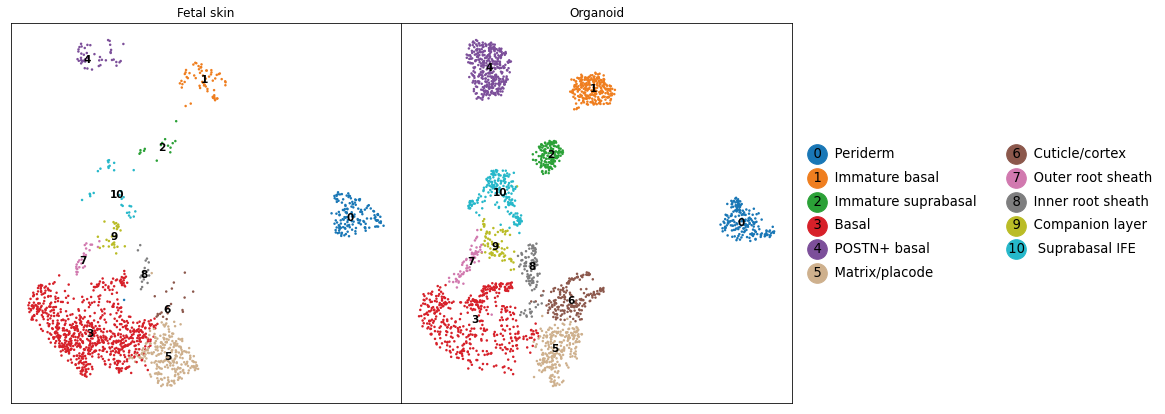

In [72]:
sk.set_figsize((14, 7))
fig, axs = plt.subplots(nrows=1, ncols=2, gridspec_kw={"wspace": 0})

sk.plot_embedding(
    pooled_KC_ad0[pooled_KC_ad0.obs.dataset == "fetal_skin"],
    basis="umap_hm",
    groupby="joint_annot2",
    size=25,
    legend_fontsize=12,
    legend_loc="none",
    title="Fetal skin",
    ax=axs[0],
    show=False,
)
sk.plot_embedding(
    pooled_KC_ad0[pooled_KC_ad0.obs.dataset == "organoid"],
    basis="umap_hm",
    groupby="joint_annot2",
    size=25,
    legend_fontsize=12,
    title="Organoid",
    ax=axs[1],
    show=False,
)
axs[0].set_xlabel("")
axs[0].set_ylabel("")
axs[1].set_xlabel("")
axs[1].set_ylabel("")
fig.savefig("figures/fig2A.pdf", bbox_inches="tight")

# FigureS2C

In [78]:
pred50 = sk.LR_predict(
    pooled_KC_ad0,
    "../20211124_integrate_rie20/rie20_lognorm.pkl",
    use_rep="X",
    key_added="rie20_annot50",
    min_prob=0.5,
    return_predict=True,
)

15117 features used for prediction


In [75]:
sk.LR_predict(
    pooled_KC_ad0,
    "../20211124_integrate_rie20/rie20_lognorm.pkl",
    use_rep="X",
    key_added="rie20_annot",
    min_prob=0,
)

15117 features used for prediction


Trying to set attribute `.uns` of view, copying.


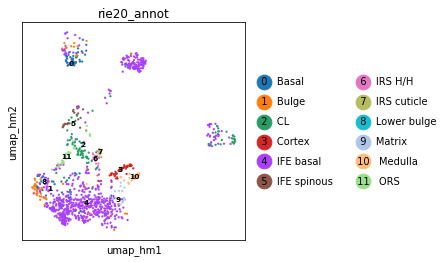

In [76]:
sk.plot_embedding(
    pooled_KC_ad0[pooled_KC_ad0.obs.rie20_annot50 != "Uncertain"],
    basis="umap_hm",
    groupby="rie20_annot",
    size=20,
);

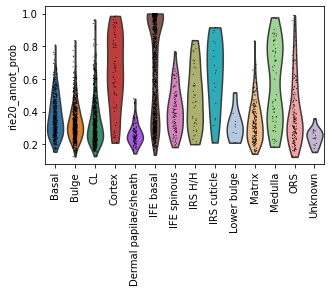

In [77]:
sk.set_figsize((5, 3))
sc.pl.violin(pooled_KC_ad0, "rie20_annot_prob", groupby="rie20_annot", rotation=90)

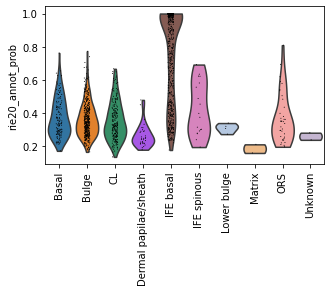

In [80]:
sk.set_figsize((5, 3))
sc.pl.violin(
    pooled_KC_ad0[pooled_KC_ad0.obs.dataset == "fetal_skin"],
    "rie20_annot_prob",
    groupby="rie20_annot",
    rotation=90,
)

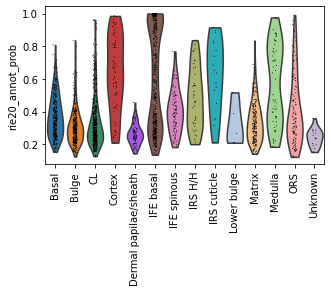

In [81]:
sk.set_figsize((5, 3))
sc.pl.violin(
    pooled_KC_ad0[pooled_KC_ad0.obs.dataset == "organoid"],
    "rie20_annot_prob",
    groupby="rie20_annot",
    rotation=90,
)

In [125]:
k_fsk = pooled_KC_ad0.obs.dataset == "fetal_skin"
k_org = pooled_KC_ad0.obs.dataset == "organoid"

In [192]:
pred50_prob_df = pd.DataFrame(
    npg.aggregate_np(
        pooled_KC_ad0.obs.joint_annot2.cat.codes,
        pred50["prob"].drop(columns=["Unknown"]).values,
        axis=0,
        func=np.median,
    ),
    index=pooled_KC_ad0.obs.joint_annot2.cat.categories,
    columns=pred50["prob"].drop(columns=["Unknown"]).columns,
)
pred50_prob_df[pred50_prob_df.values < 0.05] = 0
pred50_prob_df = pred50_prob_df.drop(
    columns=pred50_prob_df.sum(axis=0).where(lambda x: x == 0).dropna().index
)

In [193]:
pred50_prob_df2 = pd.DataFrame(
    npg.aggregate_np(
        pooled_KC_ad0.obs.joint_annot4.cat.codes,
        pred50["prob"].drop(columns=["Unknown"]).values,
        axis=0,
        func=np.median,
    ),
    index=pooled_KC_ad0.obs.joint_annot4.cat.categories,
    columns=pred50["prob"].drop(columns=["Unknown"]).columns,
)
pred50_prob_df2[pred50_prob_df2.values < 0.05] = 0
pred50_prob_df2 = pred50_prob_df2.drop(
    columns=pred50_prob_df2.sum(axis=0).where(lambda x: x == 0).dropna().index
)

In [194]:
pred50_prob_fsk_df = pd.DataFrame(
    npg.aggregate_np(
        pooled_KC_ad0.obs.joint_annot2.cat.codes[k_fsk],
        pred50["prob"].drop(columns=["Unknown"]).loc[k_fsk].values,
        axis=0,
        func=np.median,
    ),
    index=pooled_KC_ad0.obs.joint_annot2.cat.categories,
    columns=pred50["prob"].drop(columns=["Unknown"]).columns,
)
pred50_prob_fsk_df[pred50_prob_fsk_df.values < 0.05] = 0
pred50_prob_fsk_df = pred50_prob_fsk_df.drop(
    columns=pred50_prob_fsk_df.sum(axis=0).where(lambda x: x == 0).dropna().index
)

In [195]:
pred50_prob_org_df = pd.DataFrame(
    npg.aggregate_np(
        pooled_KC_ad0.obs.joint_annot2.cat.codes[k_org],
        pred50["prob"].drop(columns=["Unknown"]).loc[k_org].values,
        axis=0,
        func=np.median,
    ),
    index=pooled_KC_ad0.obs.joint_annot2.cat.categories,
    columns=pred50["prob"].drop(columns=["Unknown"]).columns,
)
pred50_prob_org_df[pred50_prob_org_df.values < 0.05] = 0
pred50_prob_org_df = pred50_prob_org_df.drop(
    columns=pred50_prob_org_df.sum(axis=0).where(lambda x: x == 0).dropna().index
)

In [281]:
def norm_by_row(df):
    return df / df.sum(axis=1).values.reshape((df.shape[0], 1))


def norm_by_col(df):
    return (df.T / df.T.sum(axis=1).values.reshape((df.T.shape[0], 1))).T


def prob_df_heatmap(df, title, figsize):
    sk.set_figsize(figsize)
    fig, axs = plt.subplots(
        nrows=1, ncols=3, sharex=True, sharey=False, gridspec_kw={"wspace": 0.05}
    )
    cbar_ax = fig.add_axes([0.91, 0.3, 0.03, 0.4])
    dfs = [df, norm_by_row(df), norm_by_col(df)]
    # sub_titles = ["no_transform", "norm_by_row", "norm_by_column"]
    for i, ax in enumerate(axs):
        sn.heatmap(
            dfs[i],
            ax=ax,
            cbar=(i == 0),
            vmin=0,
            vmax=1,
            yticklabels=(i == 0),
            cbar_ax=None if i else cbar_ax,
            cmap="viridis_r",
            linewidth=0.01,
        )
        # ax.set_title(sub_titles[i])

    fig.suptitle(title)
    return fig


def frac_df_heatmap(ad, var1, var2, title, figsize):
    sk.set_figsize(figsize)
    fig, axs = plt.subplots(
        nrows=1, ncols=3, sharex=True, sharey=False, gridspec_kw={"wspace": 0.05}
    )
    cbar_ax = fig.add_axes([0.91, 0.3, 0.03, 0.4])
    dfs = [
        sk.cross_table(ad, var1, var2, normalise="x") / 100,
        sk.cross_table(ad, var1, var2, normalise="y") / 100,
        sk.cross_table(ad, var1, var2, normalise="xy") / 100,
    ]

    for i, ax in enumerate(axs):
        sn.heatmap(
            dfs[i],
            ax=ax,
            cbar=(i == 0),
            vmin=0,
            vmax=1,
            yticklabels=(i == 0),
            cbar_ax=None if i else cbar_ax,
            cmap="viridis_r",
            linewidth=0.01,
        )
        ax.set_xlabel("")
        ax.set_ylabel("")

    fig.suptitle(title)
    return fig

Text(0.5, 0.98, 'median probability of cell type prediction')

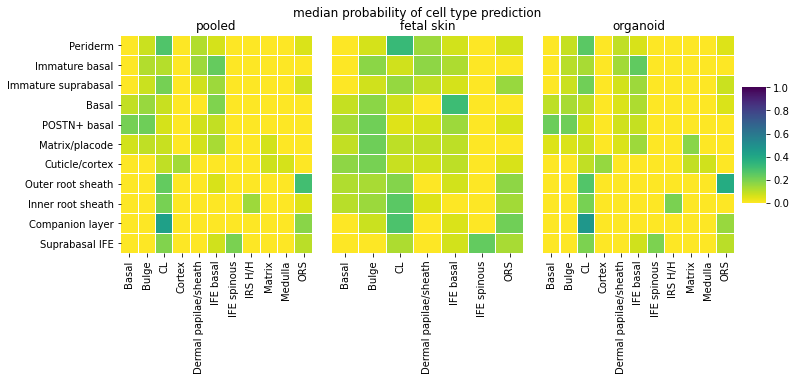

In [269]:
sk.set_figsize((11, 4))
fig, axs = plt.subplots(nrows=1, ncols=3, sharex=False, sharey=False, gridspec_kw={"wspace": 0.1})
cbar_ax = fig.add_axes([0.91, 0.3, 0.03, 0.4])
dfs = [pred50_prob_df, pred50_prob_fsk_df, pred50_prob_org_df]
sub_titles = ["pooled", "fetal skin", "organoid"]
for i, ax in enumerate(axs):
    sn.heatmap(
        dfs[i],
        ax=ax,
        cbar=(i == 0),
        vmin=0,
        vmax=1,
        yticklabels=(i == 0),
        cbar_ax=None if i else cbar_ax,
        cmap="viridis_r",
        linewidth=0.01,
    )
    ax.set_title(sub_titles[i])
fig.suptitle("median probability of cell type prediction")

In [ ]:
pred50_prob_df.head()

Basal     Bulge        CL  Cortex  \
Periderm             0.000000  0.080212  0.275827     0.0   
Immature basal       0.000000  0.115775  0.113247     0.0   
Immature suprabasal  0.000000  0.078594  0.207930     0.0   
Basal                0.093086  0.154639  0.082416     0.0   
POSTN+ basal         0.210231  0.219518  0.064281     0.0   

                     Dermal papilae/sheath  IFE basal  IFE spinous  IRS H/H  \
Periderm                          0.116783   0.063716          0.0      0.0   
Immature basal                    0.145895   0.234438          0.0      0.0   
Immature suprabasal               0.071512   0.145452          0.0      0.0   
Basal                             0.000000   0.193366          0.0      0.0   
POSTN+ basal                      0.072541   0.090050          0.0      0.0   

                     Matrix  Medulla       ORS  
Periderm                0.0      0.0  0.056967  
Immature basal          0.0      0.0  0.000000  
Immature suprabasal     0.0      0.0  0.082629  
Basal                   0.0      0.0  0.000000  
POSTN+ basal            0.0      0.0  0.000000

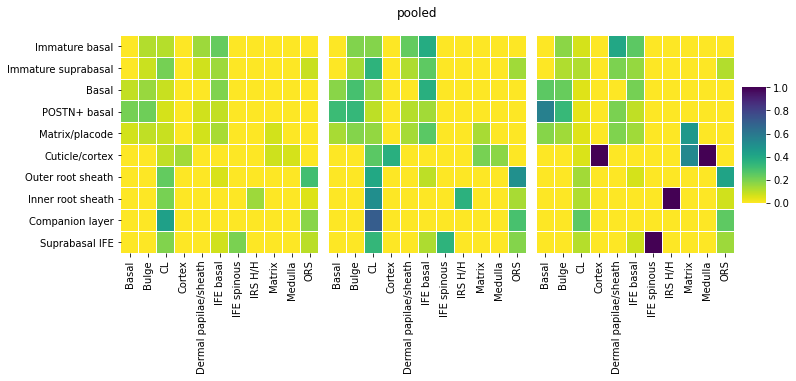

In [284]:
fig = prob_df_heatmap(pred50_prob_df.drop(index=["Periderm"]), "pooled", figsize=(11, 4))
fig.savefig("figures/figS2C_pooled_prob.pdf", bbox_inches="tight")

In [291]:
!rclone copy --drive-shared-with-me figures/figS2C_pooled_prob.pdf "google:/Fetal Skin/Figures/Figs_from_Ni/"

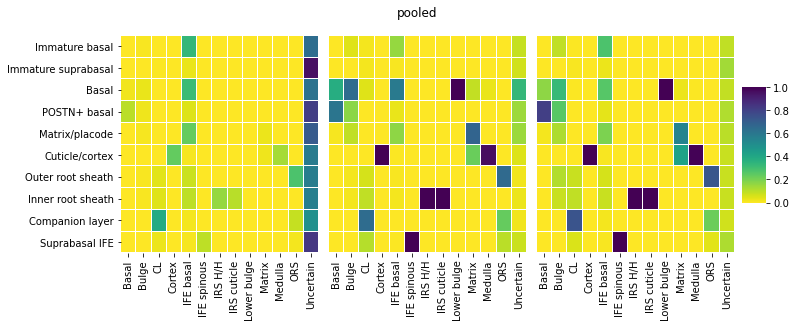

In [285]:
fig = frac_df_heatmap(
    pooled_KC_ad0[pooled_KC_ad0.obs.joint_annot2 != "Periderm"],
    "joint_annot2",
    "rie20_annot50",
    "pooled",
    figsize=(11, 4),
)
fig.savefig("figures/figS2C_pooled_frac.pdf", bbox_inches="tight")

In [292]:
!rclone copy --drive-shared-with-me figures/figS2C_pooled_frac.pdf "google:/Fetal Skin/Figures/Figs_from_Ni/"

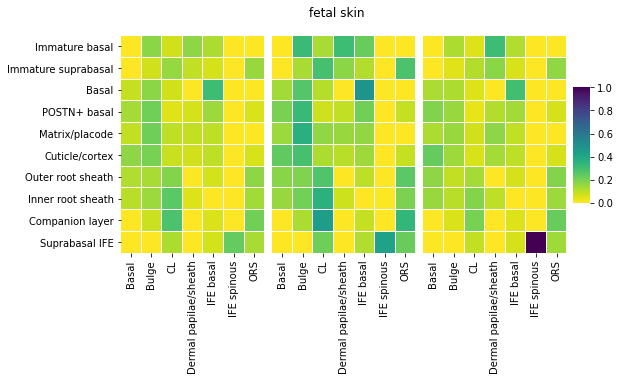

In [288]:
fig = prob_df_heatmap(pred50_prob_fsk_df.drop(index=["Periderm"]), "fetal skin", figsize=(8, 4))
fig.savefig("figures/figS2C_fsk_prob.pdf", bbox_inches="tight")

In [293]:
!rclone copy --drive-shared-with-me figures/figS2C_fsk_prob.pdf "google:/Fetal Skin/Figures/Figs_from_Ni/"

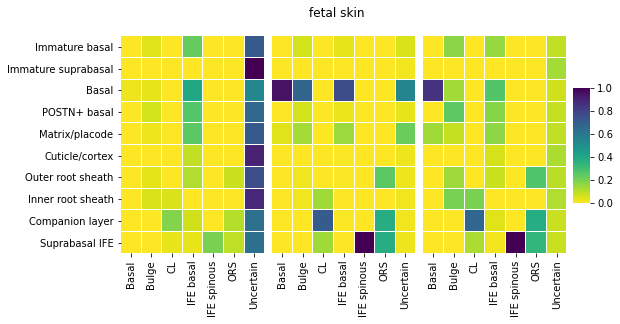

In [287]:
fig = frac_df_heatmap(
    pooled_KC_ad0[k_fsk & (pooled_KC_ad0.obs.joint_annot2 != "Periderm")],
    "joint_annot2",
    "rie20_annot50",
    "fetal skin",
    figsize=(8, 4),
)
fig.savefig("figures/figS2C_fsk_frac.pdf", bbox_inches="tight")

In [294]:
!rclone copy --drive-shared-with-me figures/figS2C_fsk_frac.pdf "google:/Fetal Skin/Figures/Figs_from_Ni/"

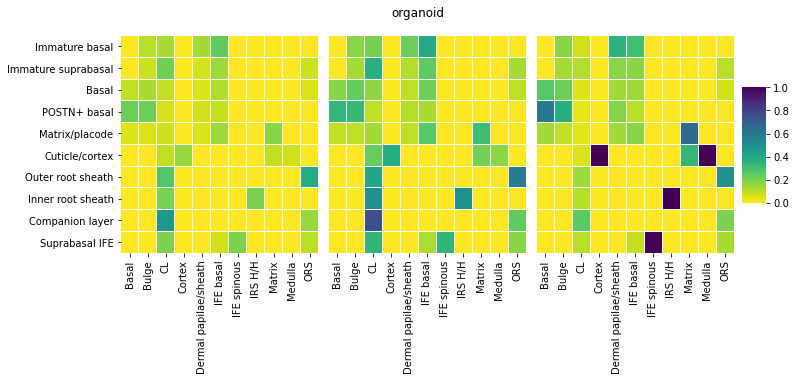

In [289]:
fig = prob_df_heatmap(pred50_prob_org_df.drop(index=["Periderm"]), "organoid", figsize=(11, 4))
fig.savefig("figures/figS2C_org_prob.pdf", bbox_inches="tight")

In [295]:
!rclone copy --drive-shared-with-me figures/figS2C_org_prob.pdf "google:/Fetal Skin/Figures/Figs_from_Ni/"

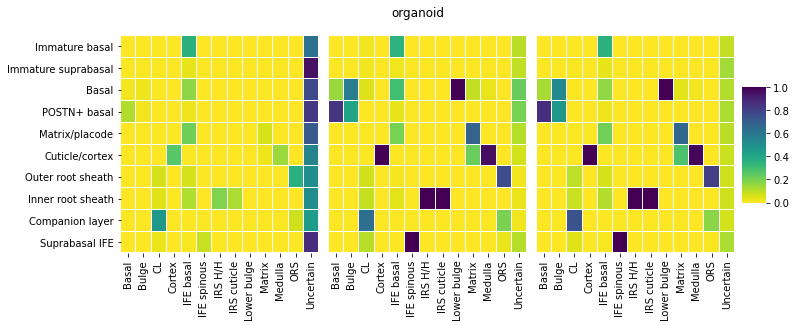

In [290]:
fig = frac_df_heatmap(
    pooled_KC_ad0[k_org & (pooled_KC_ad0.obs.joint_annot2 != "Periderm")],
    "joint_annot2",
    "rie20_annot50",
    "organoid",
    figsize=(11, 4),
)
fig.savefig("figures/figS2C_org_frac.pdf", bbox_inches="tight")

In [296]:
!rclone copy --drive-shared-with-me figures/figS2C_org_frac.pdf "google:/Fetal Skin/Figures/Figs_from_Ni/"

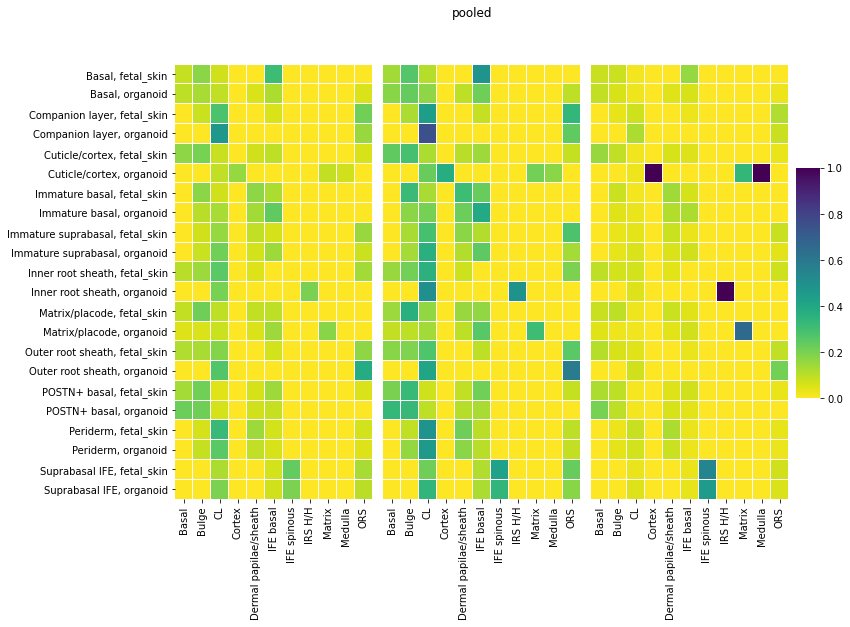

In [247]:
prob_df_heatmap(pred50_prob_df2, "pooled", figsize=(11, 8))

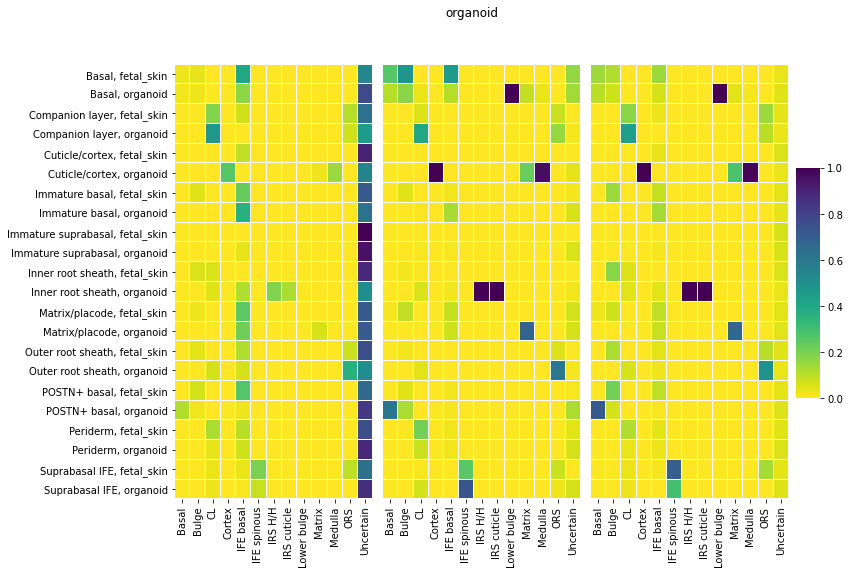

In [261]:
frac_df_heatmap(pooled_KC_ad0, "joint_annot4", "rie20_annot50", "organoid", figsize=(11, 8))

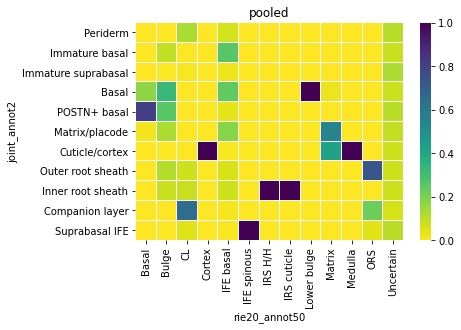

In [151]:
sk.set_figsize((6, 4))
ax = sn.heatmap(
    sk.cross_table(pooled_KC_ad0, "joint_annot2", "rie20_annot50", normalise="xy") / 100,
    cmap="viridis_r",
    linewidth=0.01,
)
ax.set_title("pooled");

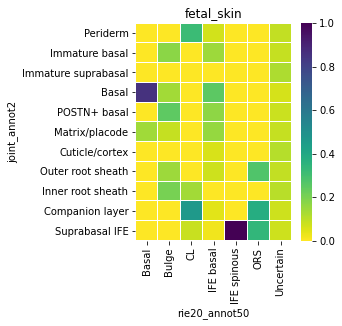

In [135]:
sk.set_figsize((3.5, 4))
ax = sn.heatmap(
    sk.cross_table(pooled_KC_ad0[k_fsk], "joint_annot2", "rie20_annot50", normalise="xy") / 100,
    cmap="viridis_r",
    linewidth=0.01,
)
ax.set_title("fetal_skin");

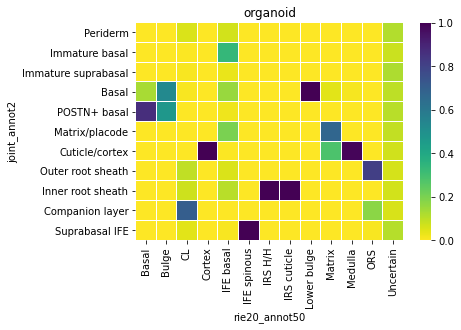

In [150]:
sk.set_figsize((6, 4))
ax = sn.heatmap(
    sk.cross_table(pooled_KC_ad0[k_org], "joint_annot2", "rie20_annot50", normalise="xy") / 100,
    cmap="viridis_r",
    linewidth=0.01,
)
ax.set_title("organoid");

In [137]:
pooled_KC_ad0.obs["joint_annot3"] = (
    pooled_KC_ad0.obs.dataset.astype(str) + ", " + pooled_KC_ad0.obs["joint_annot2"].astype(str)
)
pooled_KC_ad0.obs["joint_annot3"] = pooled_KC_ad0.obs["joint_annot3"].astype("category")

In [143]:
pooled_KC_ad0.obs["joint_annot4"] = (
    pooled_KC_ad0.obs["joint_annot2"].astype(str) + ", " + pooled_KC_ad0.obs.dataset.astype(str)
)
pooled_KC_ad0.obs["joint_annot4"] = pooled_KC_ad0.obs["joint_annot4"].astype("category")

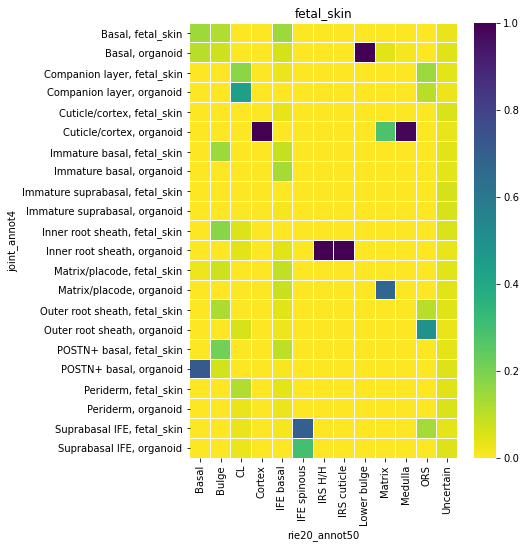

In [144]:
sk.set_figsize((6, 8))
ax = sn.heatmap(
    sk.cross_table(pooled_KC_ad0, "joint_annot4", "rie20_annot50", normalise="xy") / 100,
    cmap="viridis_r",
    linewidth=0.01,
)
ax.set_title("fetal_skin");

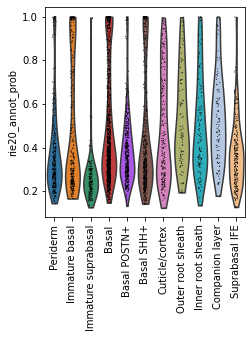

In [234]:
sc.pl.violin(pooled_KC_ad0, "rie20_annot_prob", groupby="joint_annot", rotation=90)

Trying to set attribute `.uns` of view, copying.


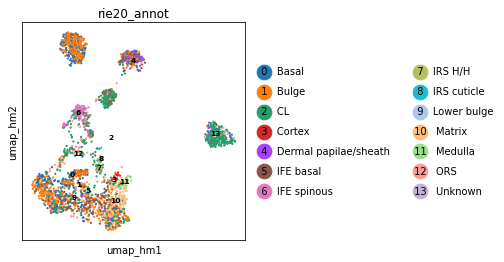

In [225]:
sk.plot_embedding(
    pooled_KC_ad0[pooled_KC_ad0.obs.rie20_annot50 == "Uncertain"],
    basis="umap_hm",
    groupby="rie20_annot",
    size=20,
);

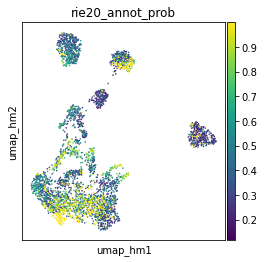

In [202]:
sc.pl.embedding(pooled_KC_ad0, basis="umap_hm", color="rie20_annot_prob", size=10);

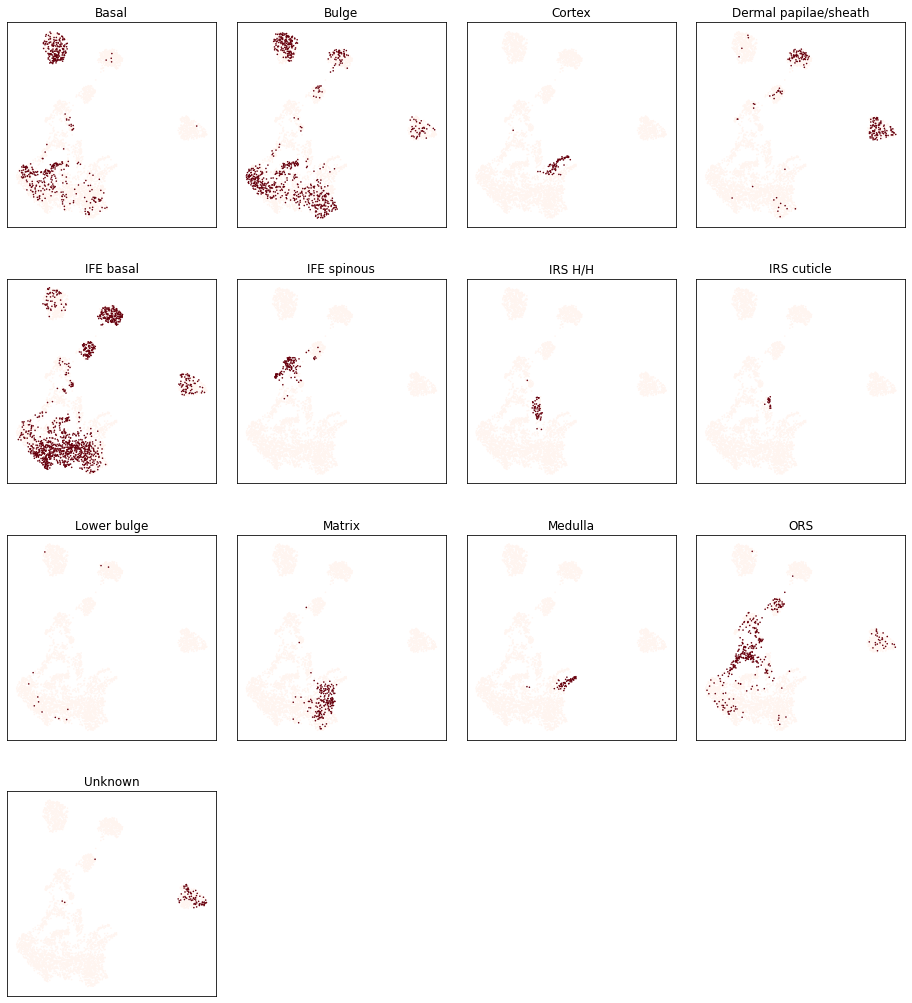

In [204]:
sk.highlight(pooled_KC_ad0, basis="umap_hm", groupby="rie20_annot", size=10, wspace=0);

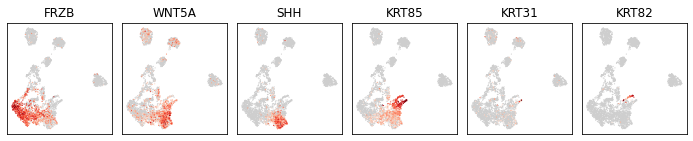

In [243]:
sk.plot_genes(
    pooled_KC_ad0,
    basis="umap_hm",
    genes=["FRZB", "WNT5A", "SHH", "KRT85", "KRT31", "KRT82"],
    figsize=(2, 2),
    size=5,
)

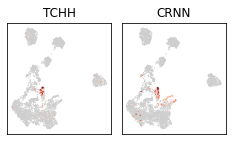

In [244]:
sk.plot_genes(
    pooled_KC_ad0, basis="umap_hm", genes=["TCHH", "KRT71", "KRT73", "CRNN"], figsize=(2, 2), size=5
)

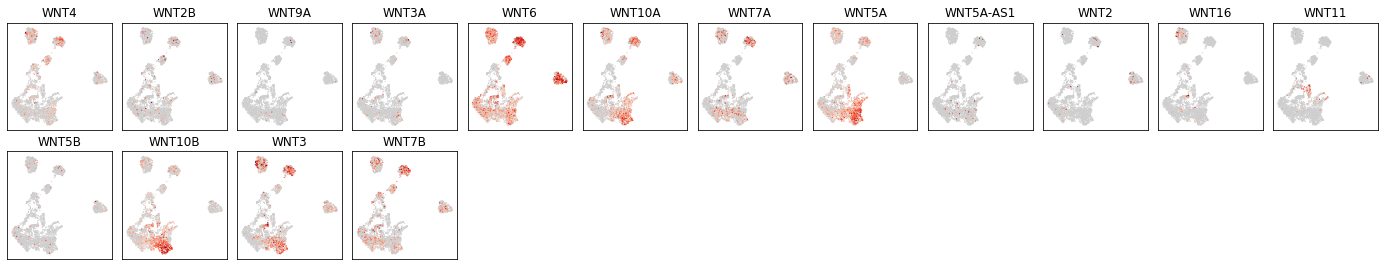

In [245]:
sk.plot_genes(
    pooled_KC_ad0,
    basis="umap_hm",
    genes=pooled_KC_ad0.var_names[pd.Series(pooled_KC_ad0.var_names).str.startswith("WNT")],
    figsize=(2, 2),
    size=5,
)

# DEG in KC

In [17]:
fsk_mkst = sk.calc_marker_stats(
    pooled_KC_ad0[pooled_KC_ad0.obs.dataset == "fetal_skin"], use_rep="X", groupby="joint_annot2"
)

In [22]:
fsk_mks = sk.filter_marker_stats(
    fsk_mkst[2], min_frac_diff=0.1, min_mean_diff=0.1, max_next_frac=0.3, single=True, how="and"
)

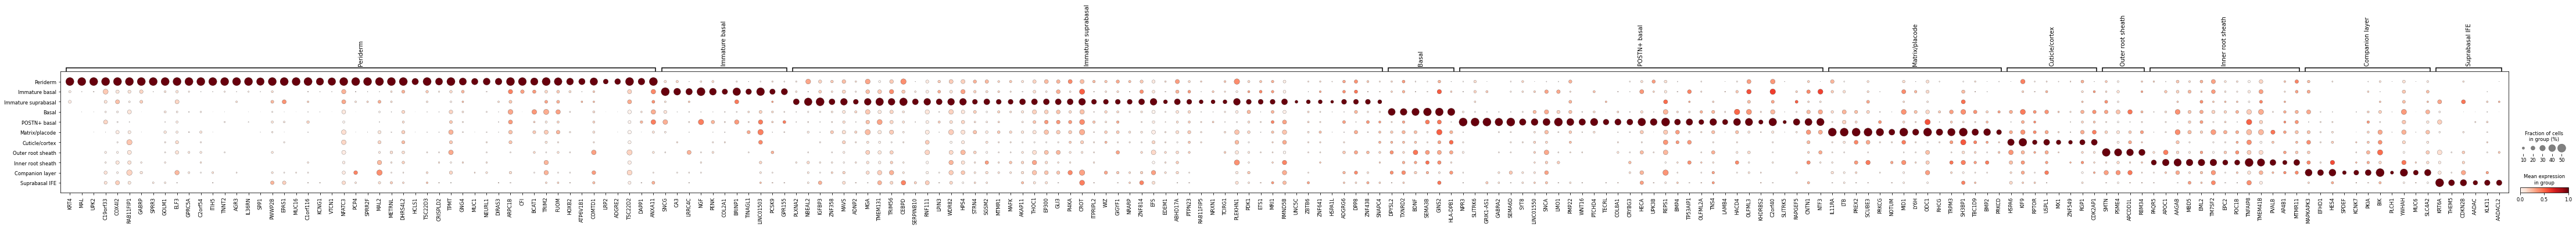

In [25]:
sk.plot_markers(
    pooled_KC_ad0[pooled_KC_ad0.obs.dataset == "fetal_skin"],
    groupby="joint_annot2",
    mks=fsk_mks,
    n_genes=50,
    standard_scale="var",
    dot_max=0.5,
)

In [39]:
org_mkst = sk.calc_marker_stats(
    pooled_KC_ad0[pooled_KC_ad0.obs.dataset == "organoid"], use_rep="X", groupby="joint_annot2"
)

In [46]:
org_mks = sk.filter_marker_stats(
    org_mkst[2], min_frac_diff=0.1, min_mean_diff=0.1, max_next_frac=0.4, single=False, how="and"
)

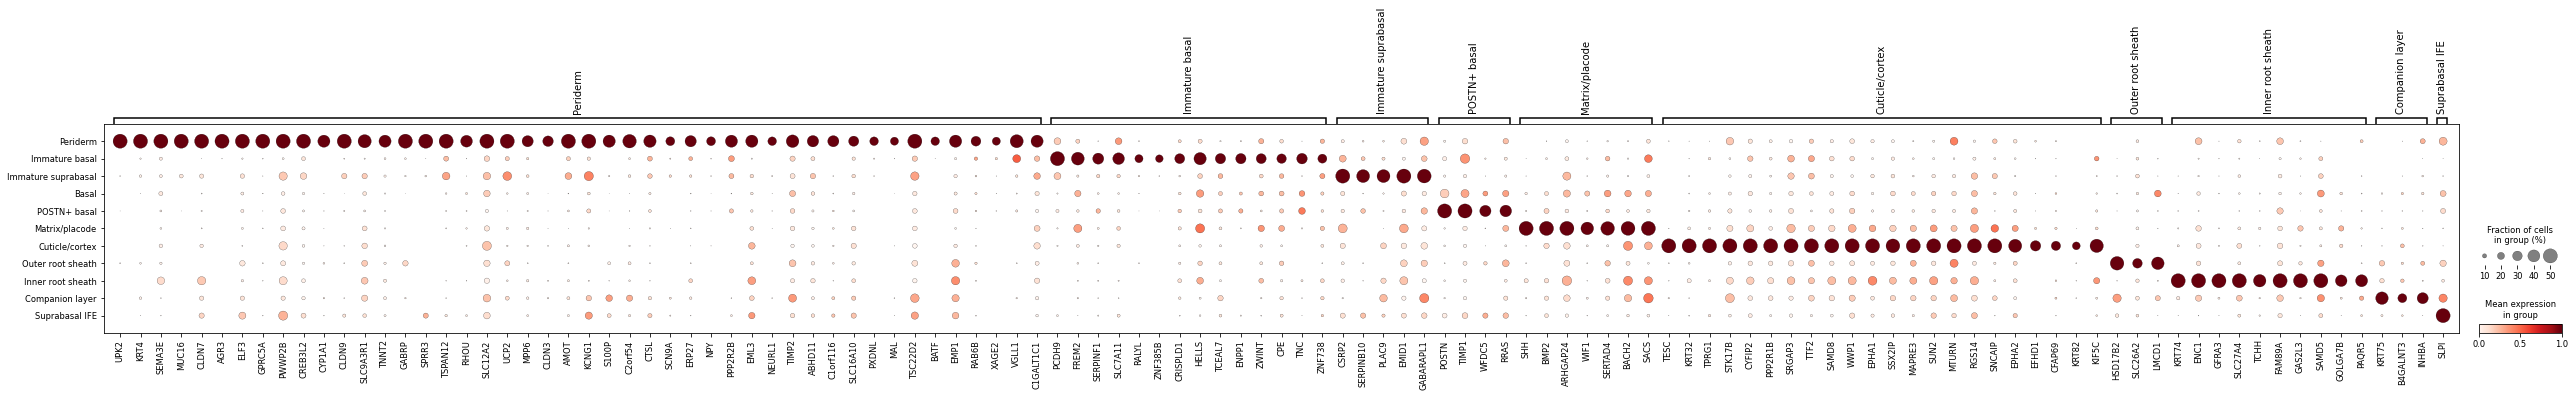

In [41]:
sk.plot_markers(
    pooled_KC_ad0[pooled_KC_ad0.obs.dataset == "organoid"],
    groupby="joint_annot2",
    mks=org_mks,
    n_genes=50,
    standard_scale="var",
    dot_max=0.5,
)

In [42]:
fsk_mks.groupby("top_frac_group").head(4)

top_frac_group  top_frac  frac_diff  max_frac_diff  \
KRT4                  Periderm  0.979866   0.846532       0.886116   
MAL                   Periderm  0.879195   0.863570       0.874226   
UPK2                  Periderm  0.812081   0.780831       0.807112   
C19orf33              Periderm  0.879195   0.613570       0.679195   
SNCG            Immature basal  0.640625   0.396181       0.500252   
CA3             Immature basal  0.406250   0.305579       0.358631   
LRRC4C          Immature basal  0.375000   0.175000       0.308333   
NGF             Immature basal  0.531250   0.242361       0.464136   
PLXNA2     Immature suprabasal  0.333333   0.270833       0.277778   
NBEAL2     Immature suprabasal  0.466667   0.211633       0.355556   
IGFBP3     Immature suprabasal  0.600000   0.433333       0.452349   
ZNF358     Immature suprabasal  0.333333   0.194993       0.219239   
DPYSL2                   Basal  0.416149   0.256149       0.268001   
TXNRD2                   Basal  0.396273   0.211088       0.250028   
BDNF                     Basal  0.437267   0.197267       0.302880   
SEMA3B                   Basal  0.478261   0.278261       0.278261   
NPR3              POSTN+ basal  0.777778   0.697778       0.705728   
SLITRK6           POSTN+ basal  0.577778   0.463684       0.468403   
GRIK1-AS1         POSTN+ basal  0.577778   0.477778       0.484028   
GABRA2            POSTN+ basal  0.466667   0.392593       0.400000   
IL11RA          Matrix/placode  0.557312   0.382816       0.446201   
LTB             Matrix/placode  0.584980   0.383738       0.407202   
PREX2           Matrix/placode  0.529644   0.339168       0.362978   
SCUBE3          Matrix/placode  0.616601   0.394379       0.426125   
HSPA6           Cuticle/cortex  0.380952   0.140952       0.214286   
KIF9            Cuticle/cortex  0.476190   0.204141       0.246941   
RPTOR           Cuticle/cortex  0.238095   0.103708       0.106418   
USPL1           Cuticle/cortex  0.333333   0.148148       0.149482   
SMTN         Outer root sheath  0.480000   0.257778       0.311056   
PSME4        Outer root sheath  0.440000   0.217778       0.241242   
APCDD1L      Outer root sheath  0.400000   0.172671       0.177778   
RBM34        Outer root sheath  0.360000   0.217708       0.265590   
PAQR5        Inner root sheath  0.277778   0.197778       0.217375   
APOC1        Inner root sheath  0.388889   0.148889       0.279514   
AAGAB        Inner root sheath  0.444444   0.175670       0.184817   
MBD5         Inner root sheath  0.388889   0.222881       0.244790   
MAPKAPK3       Companion layer  0.407407   0.204923       0.216931   
EFHD1          Companion layer  0.333333   0.277778       0.281950   
HES4           Companion layer  0.407407   0.185185       0.307407   
SPDEF          Companion layer  0.185185   0.185185       0.185185   
KRT6A           Suprabasal IFE  0.633333   0.393333       0.411111   
THEM5           Suprabasal IFE  0.333333   0.293333       0.296296   
CDKN2B          Suprabasal IFE  0.366667   0.144444       0.166667   
AADAC           Suprabasal IFE  0.233333   0.188889       0.230849   

                top_mean_group  top_mean  mean_diff  max_mean_diff  
KRT4                  Periderm  0.688789   0.651123       0.667752  
MAL                   Periderm  0.593279   0.585137       0.592148  
UPK2                  Periderm  0.433711   0.421019       0.432514  
C19orf33              Periderm  0.505679   0.403676       0.425295  
SNCG            Immature basal  0.337230   0.242330       0.299743  
CA3             Immature basal  0.225243   0.192067       0.196117  
LRRC4C          Immature basal  0.246470   0.178189       0.193889  
NGF             Immature basal  0.290730   0.163818       0.266093  
PLXNA2     Immature suprabasal  0.278886   0.251027       0.255317  
NBEAL2     Immature suprabasal  0.356744   0.245147       0.306031  
IGFBP3     Immature suprabasal  0.300109   0.215939       0.245645  
ZNF358     Immature suprabasal  0.259

In [43]:
org_mks.groupby("top_frac_group").head(4)

top_frac_group  top_frac  frac_diff  max_frac_diff  \
UPK2                  Periderm  0.648936   0.633063       0.636358   
KRT4                  Periderm  0.680851   0.628903       0.630537   
SEMA3E                Periderm  0.707447   0.489625       0.611087   
MUC16                 Periderm  0.617021   0.528971       0.614403   
PCDH9           Immature basal  0.728346   0.533378       0.536857   
FREM2           Immature basal  0.440945   0.200281       0.269639   
SERPINF1        Immature basal  0.362205   0.254875       0.286733   
SLC7A11         Immature basal  0.389764   0.203594       0.302627   
CSRP2      Immature suprabasal  0.635220   0.365511       0.442307   
SERPINB10  Immature suprabasal  0.446541   0.311541       0.331358   
PLAC9      Immature suprabasal  0.446541   0.225762       0.290291   
EMID1      Immature suprabasal  0.540881   0.275320       0.303257   
POSTN             POSTN+ basal  0.863874   0.600491       0.743874   
TIMP1             POSTN+ basal  0.594241   0.302902       0.356553   
WFDC5             POSTN+ basal  0.371728   0.236728       0.247531   
RRAS              POSTN+ basal  0.387435   0.196958       0.213987   
SHH             Matrix/placode  0.514523   0.415513       0.465272   
BMP2            Matrix/placode  0.634855   0.494230       0.506583   
ARHGAP24        Matrix/placode  0.593361   0.296331       0.354367   
WIF1            Matrix/placode  0.431535   0.300914       0.392574   
TESC            Cuticle/cortex  0.598958   0.572984       0.583085   
KRT32           Cuticle/cortex  0.802083   0.703073       0.739843   
TPRG1           Cuticle/cortex  0.593750   0.542569       0.543750   
STK17B          Cuticle/cortex  0.734375   0.461648       0.516290   
HSD17B2      Outer root sheath  0.476190   0.229437       0.396190   
SLC26A2      Outer root sheath  0.301587   0.210678       0.213537   
LMCD1        Outer root sheath  0.428571   0.242276       0.298701   
KRT74        Inner root sheath  0.633663   0.555741       0.591997   
ENC1         Inner root sheath  0.663366   0.471877       0.494535   
GFRA3        Inner root sheath  0.504950   0.465989       0.484117   
SLC27A4      Inner root sheath  0.514851   0.359007       0.389851   
KRT75          Companion layer  0.428571   0.285714       0.319661   
B4GALNT3       Companion layer  0.272727   0.184186       0.193519   
INHBA          Companion layer  0.363636   0.235977       0.268398   
SLPI            Suprabasal IFE  0.520000   0.273247       0.285957   

                top_mean_group  top_mean  mean_diff  max_mean_diff  
UPK2                  Periderm  0.395738   0.392878       0.393175  
KRT4                  Periderm  0.383092   0.369703       0.372388  
SEMA3E                Periderm  0.364060   0.311608       0.335338  
MUC16                 Periderm  0.329202   0.302800       0.328755  
PCDH9           Immature basal  0.300523   0.236862       0.241442  
FREM2           Immature basal  0.240961   0.158400       0.171015  
SERPINF1        Immature basal  0.193108   0.139919       0.161463  
SLC7A11         Immature basal  0.206801   0.133359       0.172758  
CSRP2      Immature suprabasal  0.299559   0.213911       0.215147  
SERPINB10  Immature suprabasal  0.245385   0.188183       0.188691  
PLAC9      Immature suprabasal  0.187066   0.140293       0.153378  
EMID1      Immature suprabasal  0.188227   0.115726       0.130127  
POSTN             POSTN+ basal  0.512900   0.413697       0.486810  
TIMP1             POSTN+ basal  0.256855   0.152550       0.165680  
WFDC5             POSTN+ basal  0.179470   0.117305       0.127343  
RRAS              POSTN+ basal  0.174023   0.109856       0.120889  
SHH             Matrix/placode  0.256863   0.232066       0.243431  
BMP2            Matrix/placode  0.268863   0.223201       0.230182  
ARHGAP24        Matrix/placode  0.270786   0.175625       0.180831  
WIF1            Matrix/placode  0.170979   0.131620       0.162363  
TESC            Cuticle/cortex  0.344634   0.3

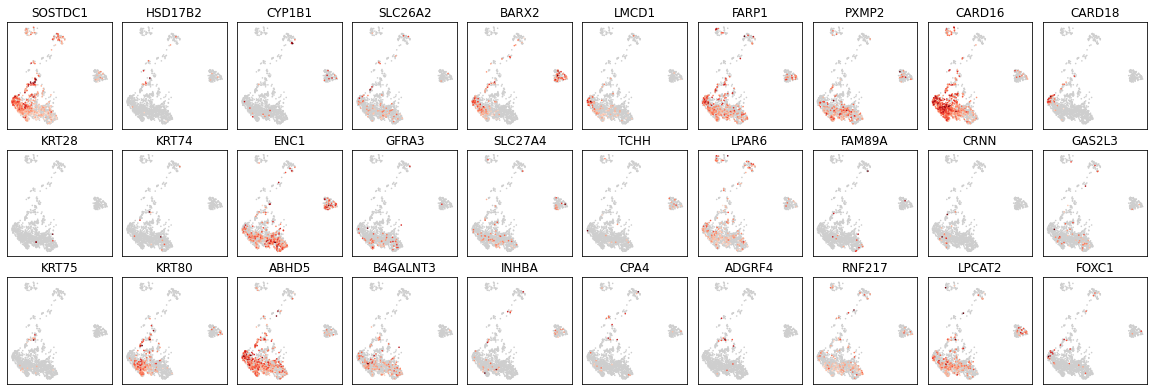

In [52]:
sk.plot_genes(
    pooled_KC_ad0[pooled_KC_ad0.obs.dataset == "fetal_skin"],
    org_mks[
        org_mks.top_frac_group.isin(["Outer root sheath", "Inner root sheath", "Companion layer"])
    ]
    .groupby("top_frac_group")
    .head(10)
    .index,
    basis="umap_hm",
    size=10,
    ncols=10,
)

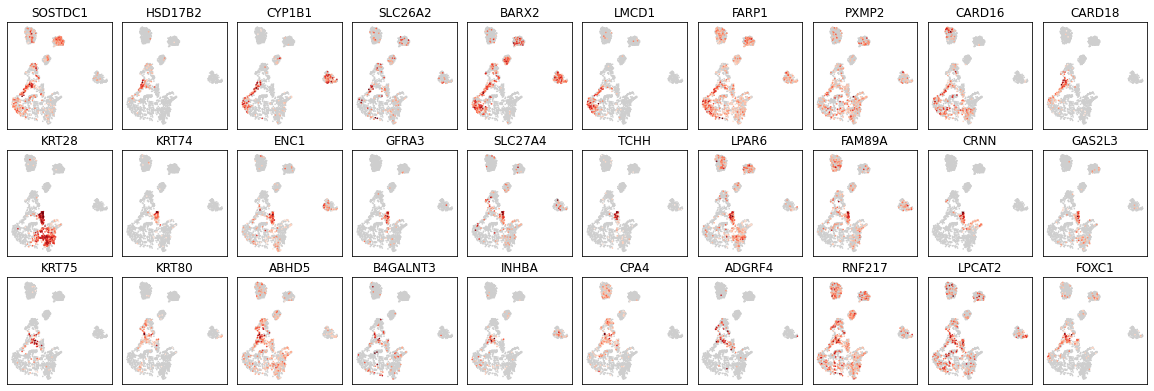

In [53]:
sk.plot_genes(
    pooled_KC_ad0[pooled_KC_ad0.obs.dataset == "organoid"],
    org_mks[
        org_mks.top_frac_group.isin(["Outer root sheath", "Inner root sheath", "Companion layer"])
    ]
    .groupby("top_frac_group")
    .head(10)
    .index,
    basis="umap_hm",
    size=10,
    ncols=10,
)

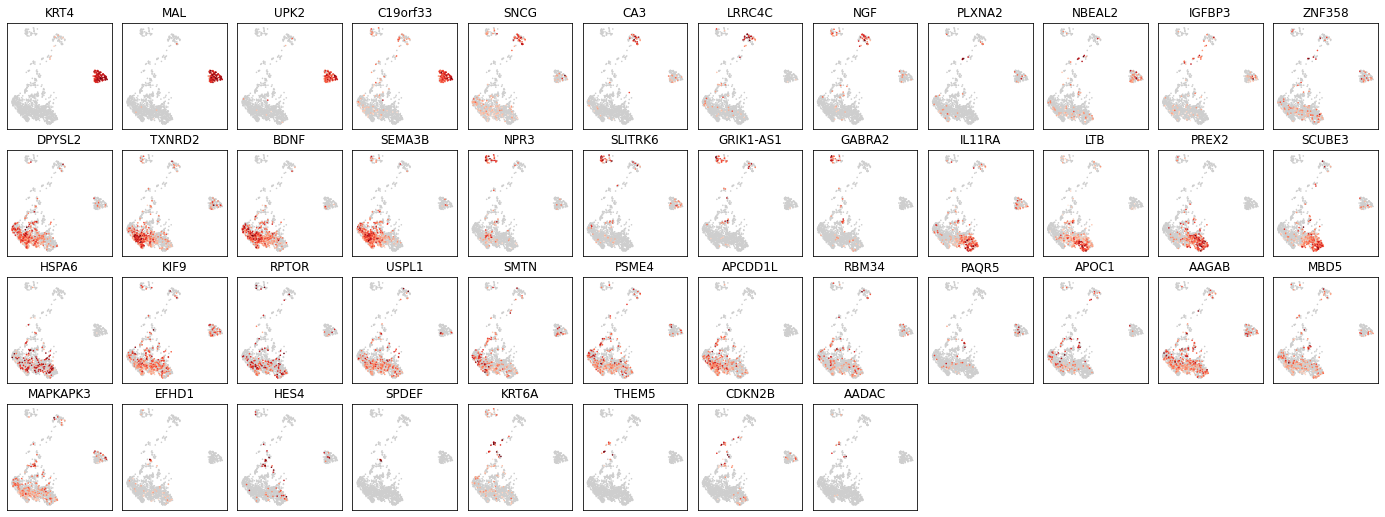

In [37]:
sk.plot_genes(
    pooled_KC_ad0[pooled_KC_ad0.obs.dataset == "fetal_skin"],
    fsk_mks.groupby("top_frac_group").head(4).index,
    basis="umap_hm",
    size=10,
)

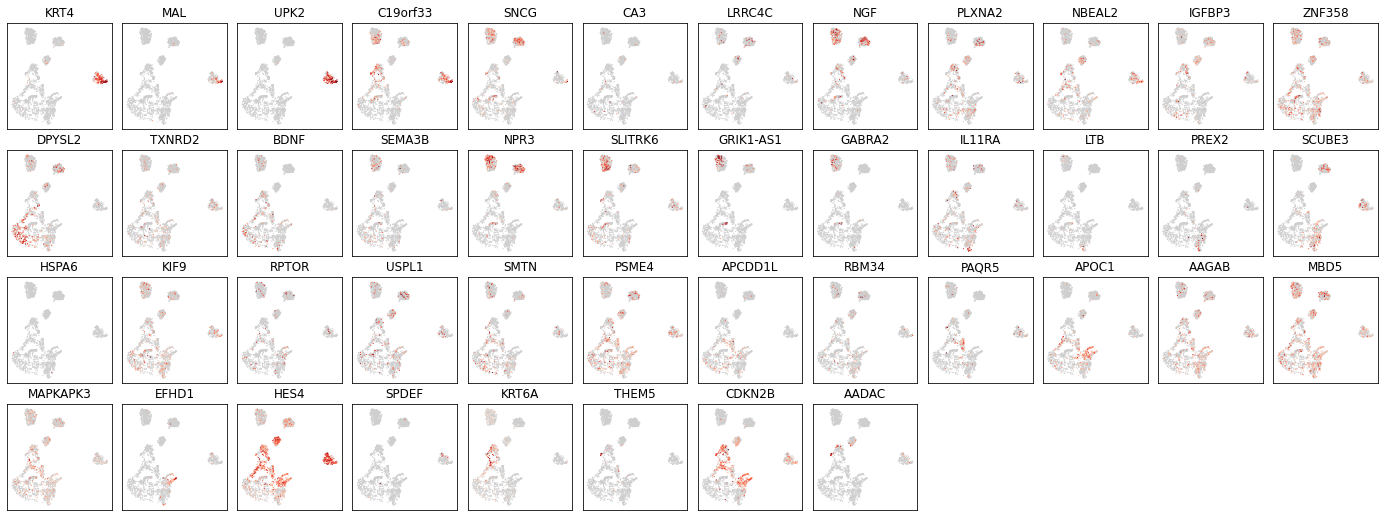

In [38]:
sk.plot_genes(
    pooled_KC_ad0[pooled_KC_ad0.obs.dataset == "organoid"],
    fsk_mks.groupby("top_frac_group").head(4).index,
    basis="umap_hm",
    size=5,
)

In [129]:
sk.paga(pooled_KC_ad0, groups="joint_annot", use_graph="neighbors_hm", key_added="hm")

AnnData object with n_obs × n_vars = 3776 × 15192
    obs: 'batch', 'chemistry_sorting', 'dataset', 'day', 'donor', 'gender', 'n_counts', 'n_genes', 'nh3_annot1', 'percent_hb', 'percent_mito', 'percent_ribo', 'percent_top50', 'rachel_annot3', 'sample_id', 'sanger_id', 'strain', 'week', 'annot', 'leiden_hm_r0_1', 'leiden_hm_r0_3', 'leiden_hm_r0_5', 'leiden_hm_r0_7', 'leiden_hm_r0_9', 'annot1', 'joint_annot', 'leiden_hm_split1', 'stage'
    var: 'gene_ids', 'hb', 'cc', 'mito', 'ribo', 'n_counts', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'hvg_full'
    uns: 'leiden', 'neighbors', 'neighbors_hm', 'pca', 'stage_colors', 'diffmap_evals', 'neighbors_diffmap_hm', 'draw_graph', 'week_colors', 'umap', 'joint_annot_sizes', 'paga_hm'
    obsm: 'X_pca', 'X_pca_hm', 'X_umap_hm', 'X_diffmap_hm', 'X_draw_graph_fa_diffmap_hm', 'X_umap_diffmap_hm'
    varm: 'PCs'
    obsp: 'distances', 'connectivities', 'neighbors_diffmap_hm_distances', 'neighbors_diffmap_hm_connectiviti

In [ ]:
sc.pl.paga()

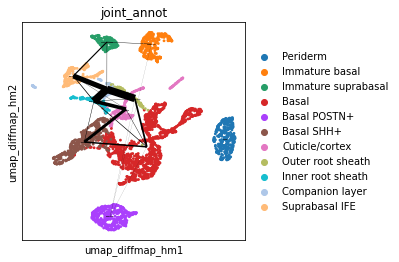

In [139]:
sk.plot_paga(
    pooled_KC_ad0,
    use_key="paga_hm",
    solid_edges="connectivities",
    basis="umap_diffmap_hm",
    color="joint_annot",
    legend_loc="right margin",
)

In [108]:
sk.diffmap(pooled_KC_ad0, use_graph="neighbors_hm", key_added="hm")

In [112]:
sk._neighbors.neighbors(pooled_KC_ad0, use_rep="X_diffmap_hm", key_added="diffmap_hm")

In [123]:
sk.umap(pooled_KC_ad0, use_graph="neighbors_diffmap_hm", key_added="diffmap_hm")

In [114]:
sk.fdg(pooled_KC_ad0, use_graph="neighbors_diffmap_hm", key_added="diffmap_hm")

In [119]:
pooled_KC_ad0.obsm["X_draw_graph_fa_diffmap_hm"].shape

(3776, 2)

In [115]:
pooled_KC_ad0

AnnData object with n_obs × n_vars = 3776 × 15192
    obs: 'batch', 'chemistry_sorting', 'dataset', 'day', 'donor', 'gender', 'n_counts', 'n_genes', 'nh3_annot1', 'percent_hb', 'percent_mito', 'percent_ribo', 'percent_top50', 'rachel_annot3', 'sample_id', 'sanger_id', 'strain', 'week', 'annot', 'leiden_hm_r0_1', 'leiden_hm_r0_3', 'leiden_hm_r0_5', 'leiden_hm_r0_7', 'leiden_hm_r0_9', 'annot1', 'joint_annot', 'leiden_hm_split1', 'stage'
    var: 'gene_ids', 'hb', 'cc', 'mito', 'ribo', 'n_counts', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'hvg_full'
    uns: 'leiden', 'neighbors', 'neighbors_hm', 'pca', 'stage_colors', 'diffmap_evals', 'neighbors_bkup', 'neighbors_diffmap_hm', 'draw_graph'
    obsm: 'X_pca', 'X_pca_hm', 'X_umap_hm', 'X_diffmap_hm', 'X_draw_graph_fa_diffmap_hm'
    varm: 'PCs'
    obsp: 'distances', 'connectivities', 'neighbors_diffmap_hm_distances', 'neighbors_diffmap_hm_connectivities'

Trying to set attribute `.uns` of view, copying.


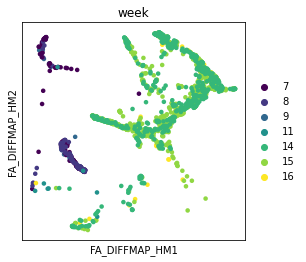

In [120]:
sc.pl.embedding(
    pooled_KC_ad0[pooled_KC_ad0.obs.dataset == "fetal_skin"],
    basis="draw_graph_fa_diffmap_hm",
    color="week",
    palette="viridis",
);

Trying to set attribute `.uns` of view, copying.


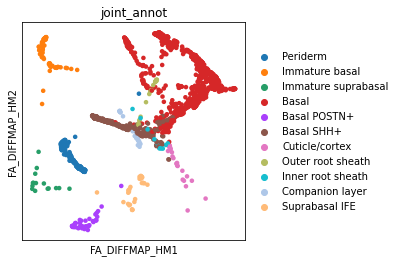

In [122]:
sk.pl.embedding(
    pooled_KC_ad0[pooled_KC_ad0.obs.dataset == "fetal_skin"],
    basis="draw_graph_fa_diffmap_hm",
    color="joint_annot",
);

Trying to set attribute `.uns` of view, copying.


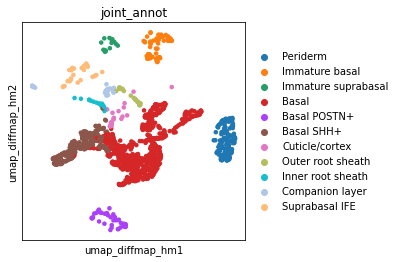

In [124]:
sk.pl.embedding(
    pooled_KC_ad0[pooled_KC_ad0.obs.dataset == "fetal_skin"],
    basis="umap_diffmap_hm",
    color="joint_annot",
);

In [104]:
sk.cross_table(pooled_KC_ad0, "donor", "joint_annot")

joint_annot  Periderm  Immature basal  Immature suprabasal  Basal  \
donor                                                               
F32                65              27                    2      0   
F33                25              10                    0      0   
F34                58               7                    5      0   
F41                 0               0                    1     26   
F50                 0               0                    0    192   
F51                 0               0                    1    268   
F61                 0              19                    0      0   
F69                 1               1                    4      0   
F71                 0               0                    2    319   
nan               188             254                  159    467   

joint_annot  Basal POSTN+  Basal SHH+  Cuticle/cortex  Outer root sheath  \
donor                                                                      
F32                     0           0               0                  0   
F33                     0           0               0                  0   
F34                     0           0               0                  0   
F41                     4           9               1                  5   
F50                     3          59               9                  5   
F51                    11         105               9                  5   
F61                     0           0               0                  0   
F69                     1           0               0                  0   
F71                    26          80               2                 10   
nan                   382         241             192                 63   

joint_annot  Inner root sheath  Companion layer  Suprabasal IFE  
donor                                                            
F32                          0                0               0  
F33                          0                0               0  
F34                          0                0               0  
F41                          0                1               3  
F50                          4                4               3  
F51                          7               15               2  
F61                          0                0               0  
F69                          0                0               1  
F71                          7                7              21  
nan                        101               77             200

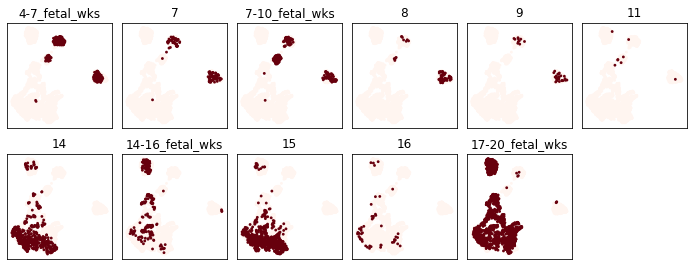

In [21]:
sk.highlight(pooled_KC_ad0, basis="umap_hm", groupby="week", figsize=(2, 2), wspace=0, ncols=6);

In [3]:
pooled_KC_ad0.obs["stage"] = sk.regroup(
    pooled_KC_ad0,
    groupby="week",
    regroups={
        "4-7 week": ["4-7_fetal_wks", "7"],
        "8-12 week": ["7-10_fetal_wks", "8", "9", "11"],
        "13-16 week": ["14", "14-16_fetal_wks", "15", "16"],
        "17-20 week": ["17-20_fetal_wks"],
    },
)

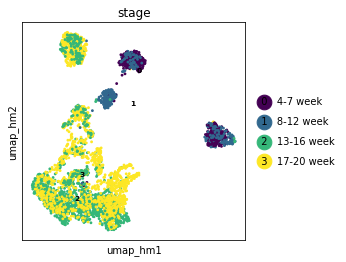

In [23]:
sk.plot_embedding(pooled_KC_ad0, basis="umap_hm", groupby="stage", palette="viridis");

In [24]:
pooled_KC_ad0.obs_names[0:2]

Index(['AAAGTAGAGTATCGAA-1-FCAImmP7316888-fetal_skin', 'AACCATGAGATTACCC-1-FCAImmP7316888-fetal_skin'], dtype='object', name='index')

In [29]:
pooled_KC_ad0.obs_names.isin(KC_ad0.obs_names + "-fetal_skin").sum()

1422

In [6]:
KC_ad0.obsm["X_umap_joint"] = np.zeros((KC_ad0.n_obs, 2)) + np.nan
KC_ad0.obsm["X_umap_joint"][
    (KC_ad0.obs_names + "-fetal_skin").isin(pooled_KC_ad0.obs_names)
] = pooled_KC_ad0.obsm["X_umap_hm"][
    pooled_KC_ad0.obs_names.isin(KC_ad0.obs_names + "-fetal_skin"), :
].copy()

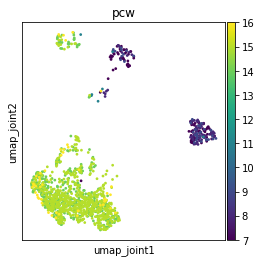

In [39]:
sk.pl.embedding(KC_ad0, basis="umap_joint", color="pcw", cmap="viridis", size=30);

In [7]:
KC_ad0.obs["stage"] = sk.regroup(
    KC_ad0,
    groupby="pcw",
    regroups={
        "6-8 pcw": ["6", "7", "8"],
        "9-11 pcw": ["9", "10", "11"],
        "12-14 pcw": ["12", "13", "14"],
        "15-16 pcw": ["15", "16"],
    },
)

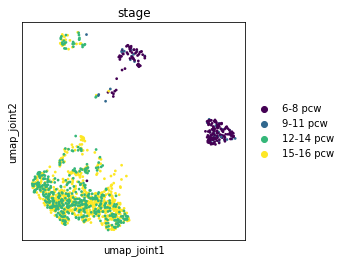

In [42]:
sk.pl.embedding(KC_ad0, basis="umap_joint", color="stage", palette="viridis", size=30);

In [141]:
KC_ad0

AnnData object with n_obs × n_vars = 1439 × 28885
    obs: 'sanger_id', 'chemistry', 'donor', 'gender', 'pcw', 'sorting', 'sample', 'chemistry_sorting', 'cell_caller', 'scrublet_score', 'cluster_scrublet_score', 'doublet_pval', 'bh_doublet_pval', 'n_counts', 'n_genes', 'percent_mito', 'percent_ribo', 'percent_hb', 'independent_annotation_refined', 'independent_annotation_broad1', 'independent_annotation_broad2', 'independent_annotation_broad3', 'independent_annotation_broad4', 'independent_annotation_broad5', 'joint_annotation', 'is_maternal', 'fig1b_annotation', 'stage', '__is_in_cluster__'
    var: 'gene_ids', 'mito', 'ribo', 'hb', 'n_cells', 'cc', 'n_counts'
    uns: 'joint_annotation_colors', 'stage_colors', 'rank_genes_groups', 'rank_genes_groups_filtered', "dendrogram_['stage']", 'dendrogram_stage'
    obsm: 'X_umap1', 'X_umap2', 'X_umap_joint', 'X_pca'

In [167]:
KC_basal_ad0 = KC_ad0[
    KC_ad0.obs.joint_annotation.isin(["Immature basal", "Basal", "Basal SHH+", "Cuticle/cortex"])
].copy()
KC_basal_ad0.obs.joint_annotation.cat.reorder_categories(
    ["Immature basal", "Basal", "Basal SHH+", "Cuticle/cortex"], inplace=True
)

In [168]:
kc_ct_mkst = sk.calc_marker_stats(KC_basal_ad0, groupby="joint_annotation")

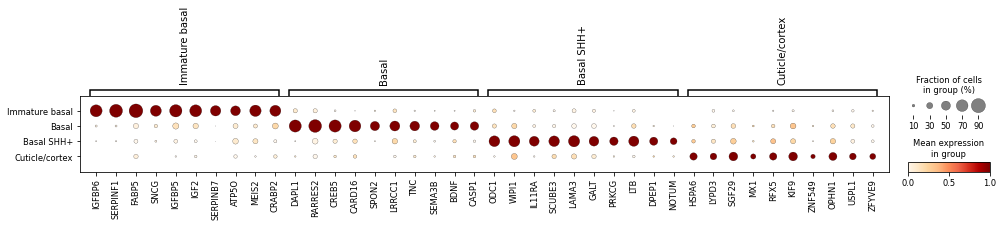

In [206]:
kc_ct_mks = sk.filter_marker_stats(kc_ct_mkst[2], max_next_frac=0.3, how="and", single=True)
fig = sk.plot_markers(
    KC_basal_ad0,
    groupby="joint_annotation",
    mks=kc_ct_mks,
    n_genes=10,
    standard_scale="var",
    cmap="OrRd",
    show=False,
)
# plt.gcf().savefig('fig2D.pdf', bbox_inches='tight')

In [207]:
kc_ct_mks.rename_axis("gene").set_index("top_frac_group", append=True)["frac_diff"].groupby(
    "top_frac_group", group_keys=False
).nlargest(3).reset_index()

gene  top_frac_group  frac_diff
0   SERPINF1  Immature basal   0.732515
1     IGFBP6  Immature basal   0.651911
2      FABP5  Immature basal   0.622275
3      CREB5           Basal   0.554838
4      DAPL1           Basal   0.551581
5    RARRES2           Basal   0.521241
6       ODC1      Basal SHH+   0.450780
7     IL11RA      Basal SHH+   0.448626
8     SCUBE3      Basal SHH+   0.427634
9      HSPA6  Cuticle/cortex   0.231346
10     SGF29  Cuticle/cortex   0.208474
11      KIF9  Cuticle/cortex   0.203798

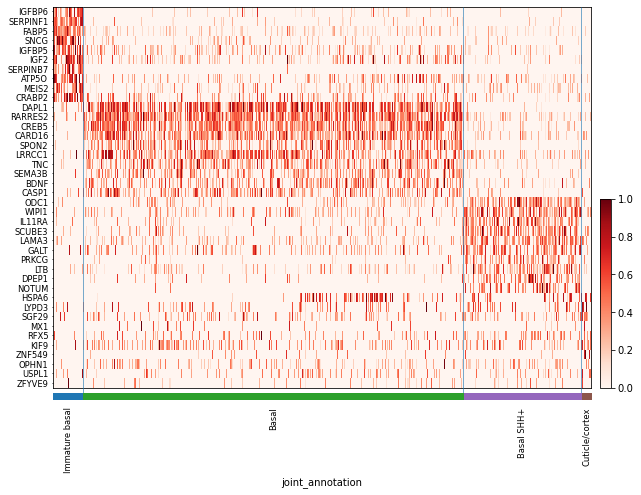

In [211]:
sc.pl.heatmap(
    KC_basal_ad0,
    kc_ct_mks.groupby("top_frac_group").head(10).index.to_list(),
    groupby="joint_annotation",
    standard_scale="var",
    show_gene_labels=True,
    swap_axes=True,
    cmap="Reds",
)

In [ ]:
sk.extract_de_table

In [8]:
kc_stage_mkst = sk.calc_marker_stats(KC_ad0, groupby="stage")

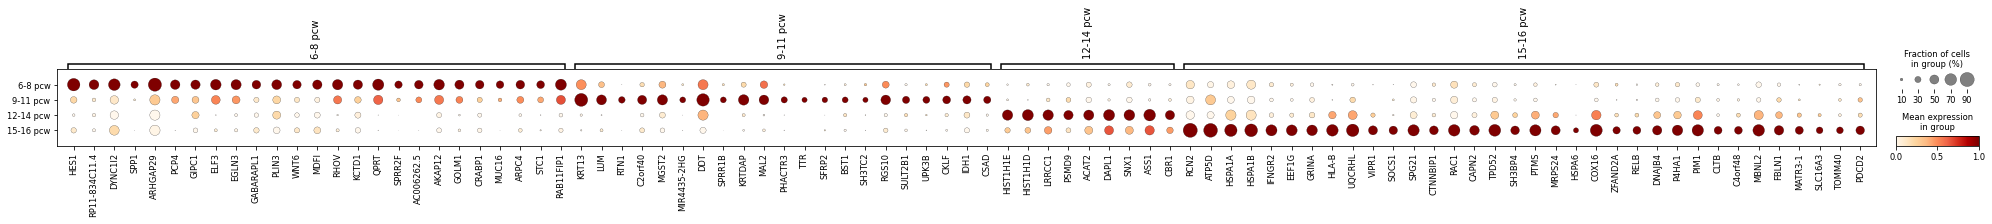

In [13]:
kc_stage_mks0 = sk.filter_marker_stats(
    kc_stage_mkst[2],
    min_frac_diff=0.1,
    min_mean_diff=0.1,
    max_next_frac=0.6,
    how="and",
    single=True,
)
sk.plot_markers(
    KC_ad0,
    groupby="stage",
    mks=kc_stage_mks0,
    n_genes=40,
    standard_scale="var",
    cmap="OrRd",
    show=False,
);

In [18]:
kc_stage_deg = sk.test_markers(KC_ad0, kc_stage_mks0, groupby="stage", method="wilcoxon")

In [21]:
kc_stage_deg[["genes", "cluster", "logfoldchanges", "pvals", "pvals_adj"]].to_csv(
    "fig2D_more_degs.tsv", sep="\t", index=False
)

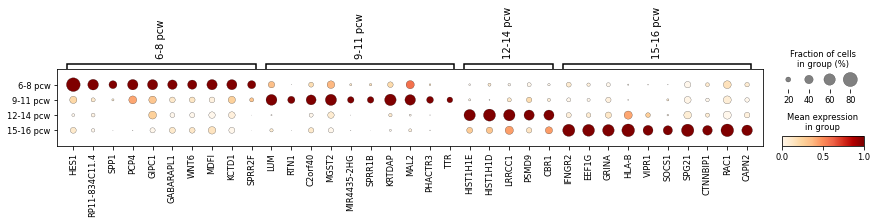

In [100]:
kc_stage_mks = sk.filter_marker_stats(kc_stage_mkst[2], max_next_frac=0.4, how="and", single=True)
fig = sk.plot_markers(
    KC_ad0,
    groupby="stage",
    mks=kc_stage_mks,
    n_genes=10,
    standard_scale="var",
    cmap="OrRd",
    show=False,
)
plt.gcf().savefig("fig2D.pdf", bbox_inches="tight")

In [67]:
kc_stage_mks

top_frac_group  top_frac  frac_diff  max_frac_diff  \
HES1                 6-8 pcw  0.767568   0.441481       0.515231   
RP11-834C11.4        6-8 pcw  0.551351   0.399177       0.411918   
SPP1                 6-8 pcw  0.372973   0.307756       0.368968   
PCP4                 6-8 pcw  0.535135   0.165570       0.525789   
GIPC1                6-8 pcw  0.518919   0.152906       0.171093   
...                      ...       ...        ...            ...   
FBLN1              15-16 pcw  0.527370   0.187501       0.331718   
MATR3-1            15-16 pcw  0.425901   0.240716       0.360684   
SLC16A3            15-16 pcw  0.333778   0.209595       0.295941   
TOMM40             15-16 pcw  0.337784   0.228851       0.229088   
PDCD2              15-16 pcw  0.464619   0.268967       0.285970   

              top_mean_group  top_mean  mean_diff  max_mean_diff  
HES1                 6-8 pcw  0.360387   0.268722       0.307518  
RP11-834C11.4        6-8 pcw  0.256474   0.198352       0.215145  
SPP1                 6-8 pcw  0.206556   0.185101       0.205166  
PCP4                 6-8 pcw  0.254232   0.144883       0.247986  
GIPC1                6-8 pcw  0.277823   0.143472       0.155087  
...                      ...       ...        ...            ...  
FBLN1              15-16 pcw  0.221662   0.103264       0.132309  
MATR3-1            15-16 pcw  0.167854   0.102554       0.129229  
SLC16A3            15-16 pcw  0.143712   0.102152       0.128646  
TOMM40             15-16 pcw  0.151942   0.100652       0.109545  
PDCD2              15-16 pcw  0.176823   0.100146       0.121250  

[64 rows x 8 columns]

In [59]:
sc.tl.rank_genes_groups(KC_ad0, groupby="stage", method="wilcoxon")

In [81]:
sc.tl.filter_rank_genes_groups(KC_ad0, min_fold_change=1.5)

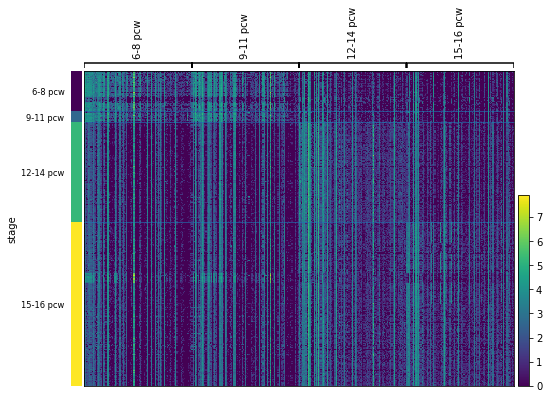

In [73]:
sc.pl.rank_genes_groups_heatmap(KC_ad0, key="rank_genes_groups", n_genes=100, dendrogram=False)

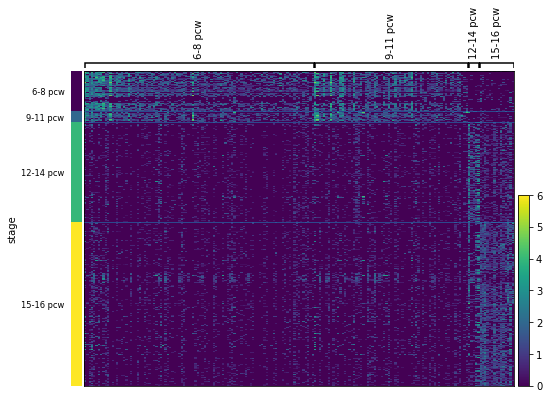

In [82]:
sc.pl.rank_genes_groups_heatmap(
    KC_ad0, key="rank_genes_groups_filtered", n_genes=100, dendrogram=False
)

In [83]:
sk.extract_de_table(KC_ad0.uns["rank_genes_groups_filtered"]).head()

cluster   ref  rank   genes     scores  logfoldchanges         pvals  \
11  6-8 pcw  rest    11    IGF2  17.419004        4.267855  5.919801e-68   
17  6-8 pcw  rest    17   CLIC3  16.408438        5.798838  1.664320e-60   
20  6-8 pcw  rest    20   ITM2C  16.249708        3.549456  2.244309e-59   
23  6-8 pcw  rest    23    MEG3  16.097990        3.215806  2.635258e-58   
24  6-8 pcw  rest    24  COL1A1  15.990054        3.031121  1.499015e-57   

       pvals_adj  
11  6.576671e-65  
17  1.335386e-57  
20  1.543497e-56  
23  1.585821e-55  
24  8.836542e-55

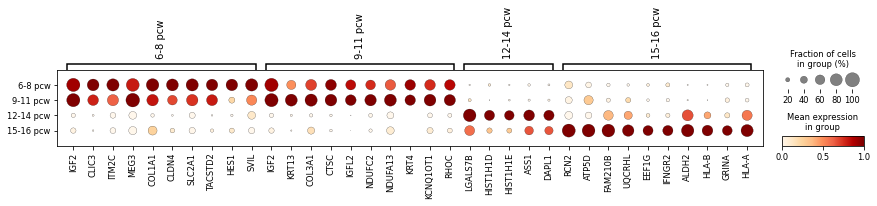

In [85]:
sk.plot_markers(
    KC_ad0,
    groupby="stage",
    mks=sk.extract_de_table(KC_ad0.uns["rank_genes_groups_filtered"])
    .rename(columns={"cluster": "top_frac_group", "genes": "index"})
    .set_index("index"),
    n_genes=10,
    standard_scale="var",
    cmap="OrRd",
)

In [216]:
fetal_ad0.obs.sanger_id.value_counts().sort_index()

4834STDY7002879     530
4834STDY7002880     307
4834STDY7002883    1106
4834STDY7038752     199
4834STDY7038753     794
FCAImmP7241240      267
FCAImmP7241241     4964
FCAImmP7316886     3888
FCAImmP7316887     3520
FCAImmP7316888     5843
FCAImmP7316896     2717
FCAImmP7316897     7052
FCAImmP7352189     2502
FCAImmP7352190     5202
FCAImmP7352191     5100
FCAImmP7462240     3388
FCAImmP7462241     4536
FCAImmP7528290     4579
FCAImmP7528291     4761
FCAImmP7528296     4095
FCAImmP7555848     3143
FCAImmP7555858     2928
FCAImmP7579212     2245
FCAImmP7579213     3077
FCAImmP7579224     1889
FCAImmP7803024     3654
FCAImmP7803025     4738
FCAImmP7803026     6435
FCAImmP7803027     5684
FCAImmP7803034     6810
FCAImmP7803035     5809
FCAImmP7803042     7369
FCAImmP7803043     6161
FCAImmP7862094     2790
FCAImmP7862095     6854
FCAImmP7862096     7230
FCAImmP7964502     3012
FCAImmP7964503     6483
FCAImmP7964504     5774
FCAImmP7964505     3196
FCAImmP7964506     3502
FCAImmP7964507  

In [26]:
ad_lr = joblib.load("../20200804_fig1/lr_model/pooled_adult_lognorm_LR.pkl")

In [33]:
ad_lr_pred = sk.LR_predict(
    fetal_ad0, ad_lr, use_rep="X", key_added="adult_annot", return_predict=True
)

20228 features used for prediction


In [31]:
ad_lr_pred["label"]

array(['adult_Macro_1', 'adult_Macro_1', 'adult_Macro_1', ..., 'adult_Macro_2', 'adult_LE1', 'adult_Macro_2'], dtype=object)

In [32]:
ad_lr_pred["prob"]

adult_B  adult_C_Melanocyte  adult_DC1  \
index                                                                         
AAACCTGGTCAGTGGA-1-4834STDY7002879  0.001345            0.013358   0.000961   
AAAGATGGTCGATTGT-1-4834STDY7002879  0.007119            0.005988   0.018890   
AAAGCAAAGATGTGGC-1-4834STDY7002879  0.000904            0.001073   0.001053   
AAAGTAGCAGATCGGA-1-4834STDY7002879  0.008527            0.014117   0.016474   
AAAGTAGTCCGCATCT-1-4834STDY7002879  0.001011            0.009585   0.002904   
...                                      ...                 ...        ...   
TTTGTCAAGTGAACGC-1-FCAImmP7964510   0.002975            0.047807   0.004387   
TTTGTCAGTGCGAAAC-1-FCAImmP7964510   0.001658            0.036173   0.004141   
TTTGTCATCCATGAGT-1-FCAImmP7964510   0.006436            0.111122   0.004035   
TTTGTCATCGCAAGCC-1-FCAImmP7964510   0.000015            0.000988   0.000086   
TTTGTCATCTGCTTGC-1-FCAImmP7964510   0.004480            0.064858   0.004665   

                                    adult_DC2  adult_F1  adult_F2  adult_F3  \
index                                                                         
AAACCTGGTCAGTGGA-1-4834STDY7002879   0.001661  0.000187  0.003764  0.000739   
AAAGATGGTCGATTGT-1-4834STDY7002879   0.114497  0.000921  0.013281  0.001847   
AAAGCAAAGATGTGGC-1-4834STDY7002879   0.002213  0.000181  0.000893  0.000717   
AAAGTAGCAGATCGGA-1-4834STDY7002879   0.014591  0.001030  0.016482  0.013777   
AAAGTAGTCCGCATCT-1-4834STDY7002879   0.001465  0.000477  0.008867  0.000658   
...                                       ...       ...       ...       ...   
TTTGTCAAGTGAACGC-1-FCAImmP7964510    0.000137  0.000457  0.029284  0.009957   
TTTGTCAGTGCGAAAC-1-FCAImmP7964510    0.000286  0.000787  0.022753  0.003556   
TTTGTCATCCATGAGT-1-FCAImmP7964510    0.007837  0.030299  0.025868  0.001244   
TTTGTCATCGCAAGCC-1-FCAImmP7964510    0.000007  0.000033  0.000312  0.000076   
TTTGTCATCTGCTTGC-1-FCAImmP7964510    0.006877  0.049302  0.023902  0.001540   

                                    adult_ILC1  adult_ILC1_NK  adult_ILC2_3  \
index                                                                         
AAACCTGGTCAGTGGA-1-4834STDY7002879    0.000339       0.003055      0.005084   
AAAGATGGTCGATTGT-1-4834STDY7002879    0.019193       0.013572      0.018952   
AAAGCAAAGATGTGGC-1-4834STDY7002879    0.000484       0.001066      0.000809   
AAAGTAGCAGATCGGA-1-4834STDY7002879    0.014076       0.017168      0.033355   
AAAGTAGTCCGCATCT-1-4834STDY7002879    0.001250       0.001031      0.001408   
...                                        ...            ...           ...   
TTTGTCAAGTGAACGC-1-FCAImmP7964510     0.001533       0.002468      0.002094   
TTTGTCAGTGCGAAAC-1-FCAImmP7964510     0.000777       0.002427      0.001276   
TTTGTCATCCATGAGT-1-FCAImmP7964510     0.006768       0.047132      0.011361   
TTTGTCATCGCAAGCC-1-FCAImmP7964510     0.000020       0.000035      0.000058   
TTTGTCATCTGCTTGC-1-FCAImmP7964510     0.007507       0.033395      0.013086   

                                    ...  adult_c3  adult_c4  adult_c5  \
index                               ...                                 
AAACCTGGTCAGTGGA-1-4834STDY7002879  ...  0.000694  0.007265  0.000190   
AAAGATGGTCGATTGT-1-4834STDY7002879  ...  0.001354  0.003098  0.000686   
AAAGCAAAGATGTGGC-1-4834STDY7002879  ...  0.000310  0.001997  0.000173   
AAAGTAGCAGATCGGA-1-4834STDY7002879  ...  0.001684  0.014420  0.003745   
AAAGTAGTCCGCATCT-1-4834STDY7002879  ...  0.000125  0.000944  0.000478   
...                                 ...       ...       ...       ...   
TTTGTCAAGTGAACGC-1-FCAImmP7964510   ...  0.001459  0.007262  0.002195   
TTTGTCAGTGCGAAAC-1-FCAImmP7964510   ...  0.000523  0.002377  0.001412   
TTTGTCATCCATGAGT-1-FCAImmP7964510   ...  0.000263  0.011445  0.005636   
TTTGTCATCGCAAGCC-1-FCAImmP7964510   ...  0.000008  0.000125  0.000091   
TTTGTCATCTGCTTGC-1-FCAImmP7964510   ...  0.000882  0.016349  0.011987   

   

In [104]:
k_t1 = (fetal_ad0.obs.pcw <= 12).values
k_t2 = (fetal_ad0.obs.pcw > 12).values

In [188]:
pred_prob_df1 = pd.DataFrame(
    npg.aggregate(
        fetal_ad0.obs.fig1b_annotation.cat.codes[k_t1], ad_lr_pred["prob"][k_t1], "mean", axis=0
    ),
    index=fetal_ad0.obs.fig1b_annotation.cat.categories,
    columns=ad_lr_pred["prob"].columns,
)

In [106]:
pred_prob_df2 = pd.DataFrame(
    npg.aggregate(
        fetal_ad0.obs.fig1b_annotation.cat.codes[k_t2], ad_lr_pred["prob"][k_t2], "mean", axis=0
    ),
    index=fetal_ad0.obs.fig1b_annotation.cat.categories,
    columns=ad_lr_pred["prob"].columns,
)

In [107]:
pred_frac_df1 = sk.cross_table(fetal_ad0[k_t1, :], "fig1b_annotation", "adult_annot", normalise="x")

In [108]:
pred_frac_df2 = sk.cross_table(fetal_ad0[k_t2, :], "fig1b_annotation", "adult_annot", normalise="x")

In [ ]:
(ad_lr_pred["prob"].max(axis=1) < 0.5).sum()

51921

In [42]:
(ad_lr_pred["prob"].max(axis=1) >= 0.5).sum()

134661

In [43]:
fetal_ad0.obs["adult_annot"] = ad_lr_pred["label"]

In [44]:
fetal_ad0.obs["adult_annot_ge50"] = ad_lr_pred["label"]
k_lt50 = ad_lr_pred["prob"].max(axis=1) >= 0.5
fetal_ad0.obs.loc[k_lt50, "adult_annot_ge50"] = "uncertain"

In [109]:
pred50_frac_df1 = sk.cross_table(
    fetal_ad0[k_t1, :], "fig1b_annotation", "adult_annot_ge50", normalise="x"
)

In [110]:
pred50_frac_df2 = sk.cross_table(
    fetal_ad0[k_t2, :], "fig1b_annotation", "adult_annot_ge50", normalise="x"
)

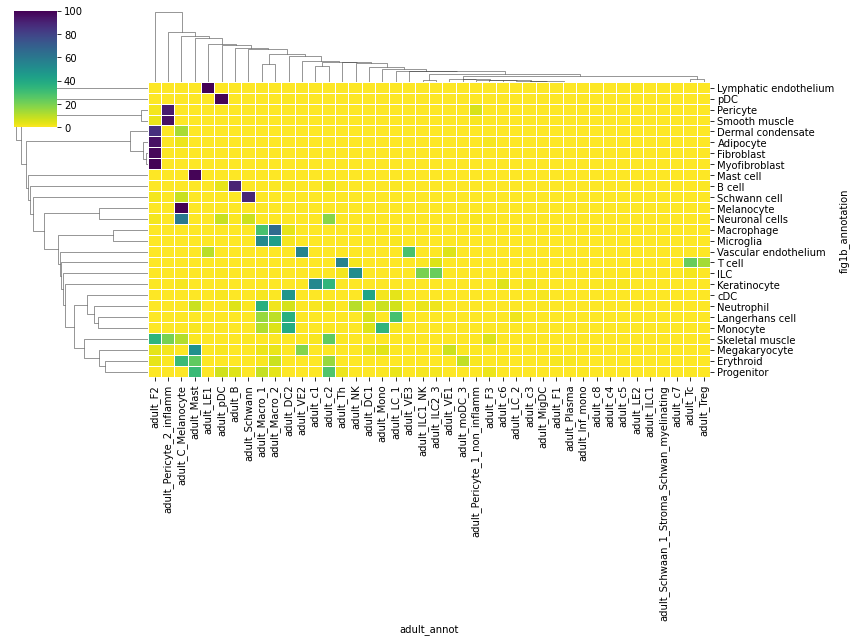

In [58]:
sn.clustermap(pred_frac_df, cmap="viridis_r", linewidth=0.01, figsize=(12, 9))

<AxesSubplot:>

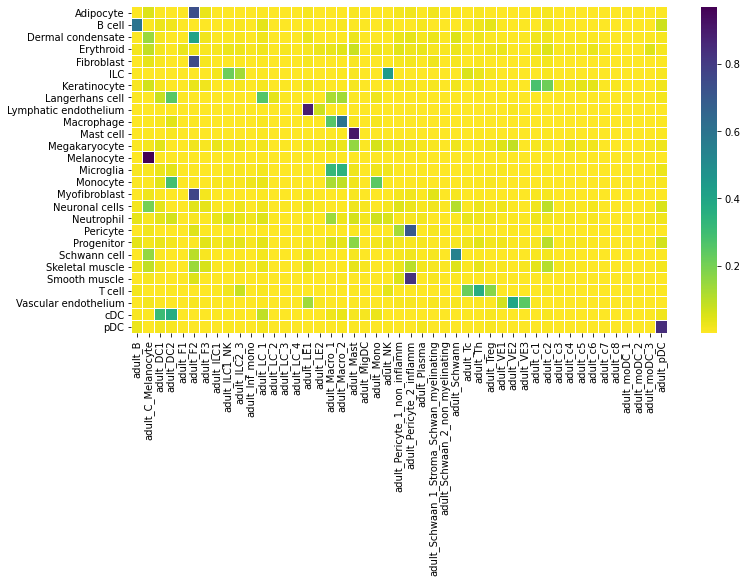

In [73]:
sk.set_figsize((12, 6))
sn.heatmap(pred_prob_df, cmap="viridis_r", linewidth=0.01)

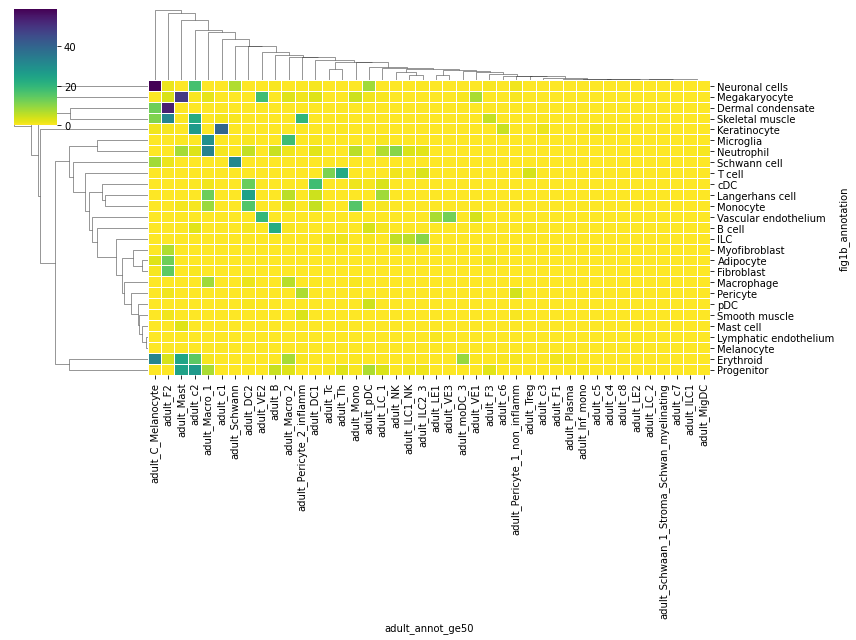

In [61]:
sn.clustermap(
    pred50_frac_df.drop(columns=["uncertain"]), cmap="viridis_r", linewidth=0.01, figsize=(12, 9)
)

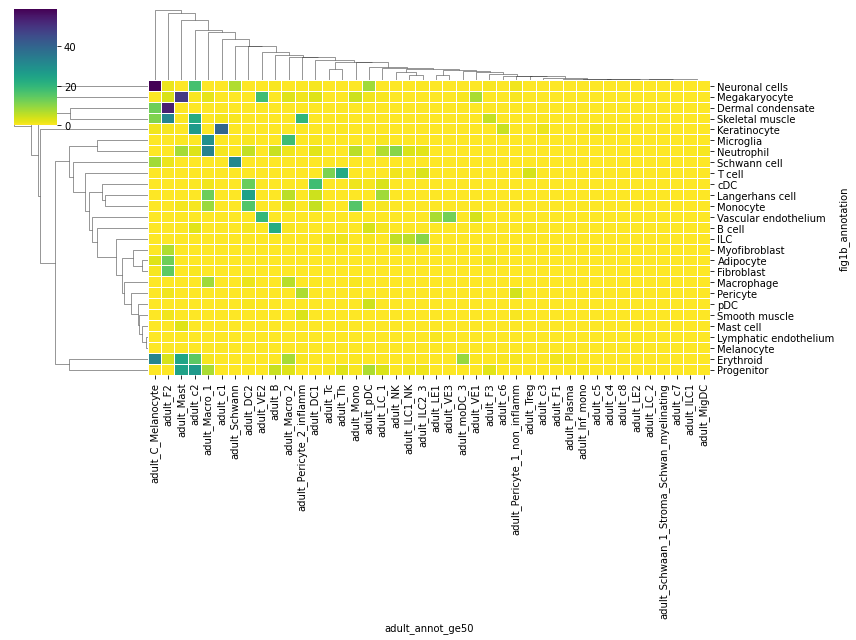

In [61]:
sn.clustermap(
    pred50_frac_df.drop(columns=["uncertain"]), cmap="viridis_r", linewidth=0.01, figsize=(12, 9)
)

In [111]:
pred_df1 = pd.merge(
    pd.melt(
        pred_frac_df1.reset_index().rename(columns={"fig1b_annotation": "fetal_celltype"}),
        id_vars="fetal_celltype",
        var_name="adult_celltype",
        value_name="fraction",
    ).set_index(["fetal_celltype", "adult_celltype"]),
    pd.melt(
        pred_prob_df1.reset_index().rename(columns={"index": "fetal_celltype"}),
        id_vars="fetal_celltype",
        var_name="adult_celltype",
        value_name="probability",
    ).set_index(["fetal_celltype", "adult_celltype"]),
    left_index=True,
    right_index=True,
).reset_index()

In [112]:
pred_df2 = pd.merge(
    pd.melt(
        pred_frac_df2.reset_index().rename(columns={"fig1b_annotation": "fetal_celltype"}),
        id_vars="fetal_celltype",
        var_name="adult_celltype",
        value_name="fraction",
    ).set_index(["fetal_celltype", "adult_celltype"]),
    pd.melt(
        pred_prob_df2.reset_index().rename(columns={"index": "fetal_celltype"}),
        id_vars="fetal_celltype",
        var_name="adult_celltype",
        value_name="probability",
    ).set_index(["fetal_celltype", "adult_celltype"]),
    left_index=True,
    right_index=True,
).reset_index()

In [113]:
pred50_df1 = pd.merge(
    pd.melt(
        pred50_frac_df1.reset_index().rename(columns={"fig1b_annotation": "fetal_celltype"}),
        id_vars="fetal_celltype",
        var_name="adult_celltype",
        value_name="fraction",
    ).set_index(["fetal_celltype", "adult_celltype"]),
    pd.melt(
        pred_prob_df1.reset_index().rename(columns={"index": "fetal_celltype"}),
        id_vars="fetal_celltype",
        var_name="adult_celltype",
        value_name="probability",
    ).set_index(["fetal_celltype", "adult_celltype"]),
    how="outer",
    left_index=True,
    right_index=True,
).reset_index()

In [114]:
pred50_df2 = pd.merge(
    pd.melt(
        pred50_frac_df2.reset_index().rename(columns={"fig1b_annotation": "fetal_celltype"}),
        id_vars="fetal_celltype",
        var_name="adult_celltype",
        value_name="fraction",
    ).set_index(["fetal_celltype", "adult_celltype"]),
    pd.melt(
        pred_prob_df2.reset_index().rename(columns={"index": "fetal_celltype"}),
        id_vars="fetal_celltype",
        var_name="adult_celltype",
        value_name="probability",
    ).set_index(["fetal_celltype", "adult_celltype"]),
    how="outer",
    left_index=True,
    right_index=True,
).reset_index()

In [124]:
pred50_frac_df1

adult_annot_ge50       adult_B  adult_C_Melanocyte  adult_DC1  adult_DC2  \
fig1b_annotation                                                           
Adipocyte                 0.00                0.00       0.00       0.00   
B cell                   30.50                0.00       0.00       0.00   
Dermal condensate         0.00                1.02       0.00       0.00   
Erythroid                 0.36               11.87       0.29       0.00   
Fibroblast                0.02                1.02       0.00       0.00   
ILC                       0.00                0.00       0.00       0.00   
Keratinocyte              0.00                2.16       0.00       0.00   
Langerhans cell           0.00                0.00       5.28      31.69   
Lymphatic endothelium     0.00                0.00       0.00       0.00   
Macrophage                0.01                0.01       0.38       2.06   
Mast cell                 0.00                0.00       0.00       0.00   
Megakaryocyte             0.00                0.00       3.70       0.00   
Melanocyte                0.00                0.00       0.00       0.00   
Microglia                 0.07                0.00       0.65       0.51   
Monocyte                  0.11                0.00       7.24      18.70   
Myofibroblast             0.00                0.04       0.00       0.00   
Neuronal cells            0.54               59.92       0.78       0.00   
Neutrophil                1.54                0.00       3.08       5.38   
Pericyte                  0.00                0.44       0.00       0.00   
Progenitor                4.91                0.00       0.75       0.00   
Schwann cell              0.00               16.40       0.00       0.00   
Skeletal muscle           0.13               10.30       0.06       0.00   
Smooth muscle             0.00                0.00       0.00       0.00   
T cell                    0.06                0.00       0.00       0.00   
Vascular endothelium      0.00                0.21       0.00       0.00   
cDC                       0.06                0.00      23.29      16.01   
pDC                       0.00                0.00       0.00       0.00   

adult_annot_ge50       adult_F1  adult_F2  adult_F3  adult_ILC1  \
fig1b_annotation                                                  
Adipocyte                  0.00      1.47      0.00        0.00   
B cell                     0.00      0.00      0.00        0.00   
Dermal condensate          0.00     77.55      2.04        0.00   
Erythroid                  0.29      8.01      0.00        0.00   
Fibroblast                 0.00     17.68      0.09        0.00   
ILC                        0.00      0.02      0.00        0.38   
Keratinocyte               0.00      3.45      0.00        0.00   
Langerhans cell            0.00      0.00      0.00        0.00   
Lymphatic endothelium      0.00      0.00      0.00        0.00   
Macrophage                 0.00      0.02      0.00        0.00   
Mast cell                  0.00      0.00      0.17        0.00   
Megakaryocyte              0.00      4.44      0.00        0.00   
Melanocyte                 0.00      0.00      0.00        0.00   
Microglia                  0.00      0.00      0.00        0.00   
Monocyte                   0.00      0.04      0.19        0.07   
Myofibroblast              0.00      7.87      0.04        0.00   
Neuronal cells             0.00      1.68      0.66        0.00   
Neutrophil                 0.00      0.00      0.00        0.77   
Pericyte                   0.00      3.35      0.00        0.00   
Progenitor                 0.00      0.00      3.40        0.00   
Schwann cell               0.00      3.09      0.00        0.00   
Skeletal muscle            0.00     28.87      5.87        0.00   
Smooth muscle              0.00      2.81      0.00        0.00   
T cell                     0.00      0.00      0.00        0.00   
Vascular endothelium       0.00      0.42      0.00  

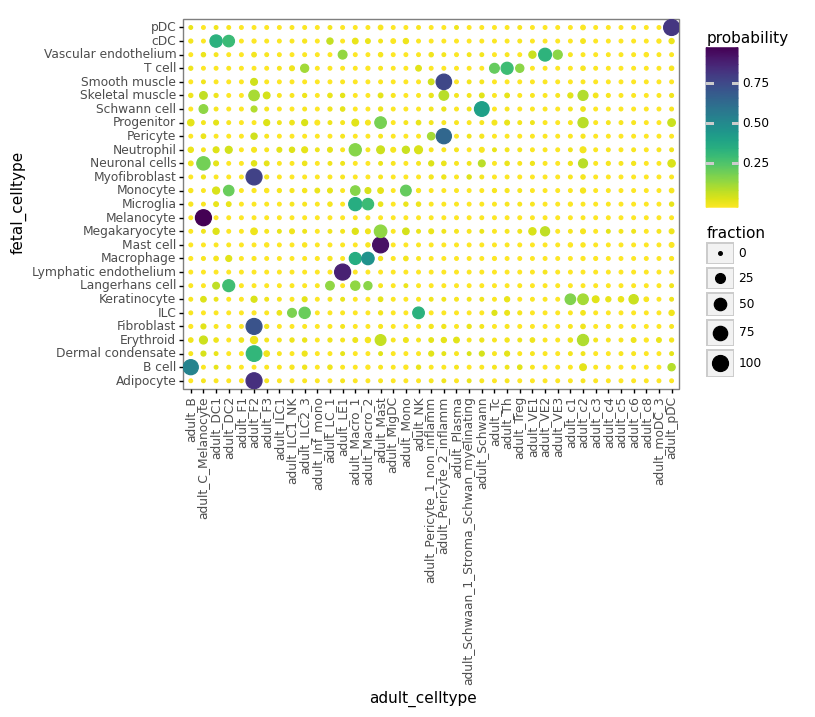

<ggplot: (8730462544541)>

In [115]:
(
    ggplot(
        pred_df1, aes(x="adult_celltype", y="fetal_celltype", size="fraction", color="probability")
    )
    + pln.geom_point()
    + pln.scale_color_cmap("viridis_r")
    + pln.theme_bw()
    + pln.theme(axis_text_x=pln.element_text(rotation=90), panel_grid=pln.element_blank())
)

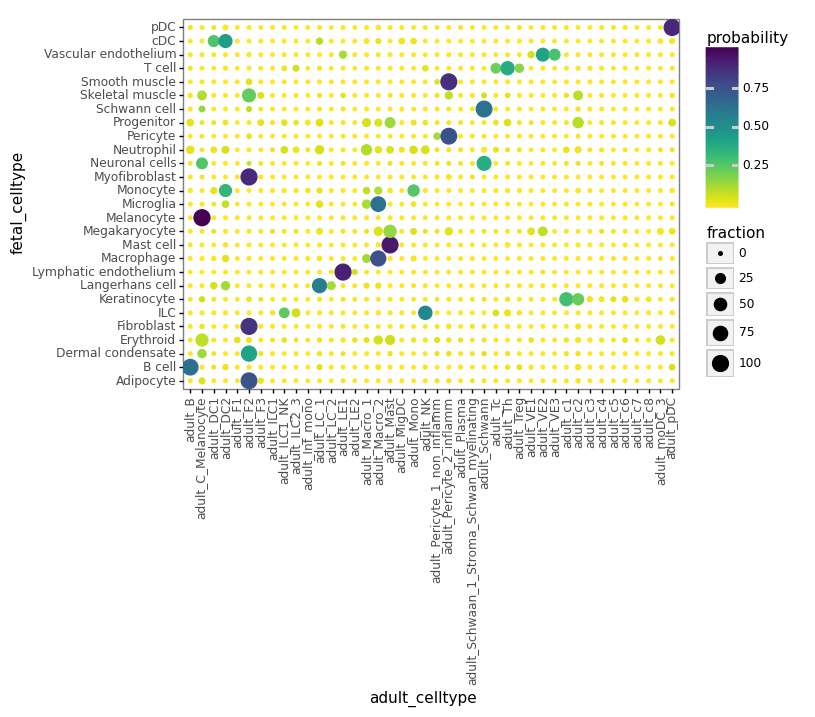

<ggplot: (8730462545821)>

In [116]:
(
    ggplot(
        pred_df2, aes(x="adult_celltype", y="fetal_celltype", size="fraction", color="probability")
    )
    + pln.geom_point()
    + pln.scale_color_cmap("viridis_r")
    + pln.theme_bw()
    + pln.theme(axis_text_x=pln.element_text(rotation=90), panel_grid=pln.element_blank())
)

In [179]:
pred_df3 = pd.concat([pred_df1.assign(stage="1st"), pred_df2.assign(stage="2nd")]).assign(
    fetal_celltype_stage=lambda x: x.fetal_celltype + ", " + x.stage
)

In [180]:
pred_df3

fetal_celltype adult_celltype  fraction  probability stage  \
0                Adipocyte        adult_B      0.00     0.002534   1st   
1                   B cell        adult_B     84.86     0.523695   1st   
2        Dermal condensate        adult_B      0.00     0.012612   1st   
3                Erythroid        adult_B      0.36     0.021475   1st   
4               Fibroblast        adult_B      0.02     0.003612   1st   
...                    ...            ...       ...          ...   ...   
1129         Smooth muscle      adult_pDC      0.00     0.000512   2nd   
1130                T cell      adult_pDC      0.00     0.004179   2nd   
1131  Vascular endothelium      adult_pDC      0.00     0.001334   2nd   
1132                   cDC      adult_pDC      0.88     0.013743   2nd   
1133                   pDC      adult_pDC     98.92     0.873721   2nd   

           fetal_celltype_stage  
0                Adipocyte, 1st  
1                   B cell, 1st  
2        Dermal condensate, 1st  
3                Erythroid, 1st  
4               Fibroblast, 1st  
...                         ...  
1129         Smooth muscle, 2nd  
1130                T cell, 2nd  
1131  Vascular endothelium, 2nd  
1132                   cDC, 2nd  
1133                   pDC, 2nd  

[2187 rows x 6 columns]

In [189]:
pred_df3.where(lambda x: (x.fetal_celltype == "B cell") & (x.adult_celltype == "adult_B")).dropna()

fetal_celltype adult_celltype  fraction  probability stage  \
1         B cell        adult_B     84.86     0.523695   1st   
1         B cell        adult_B     92.42     0.625437   2nd   

  fetal_celltype_stage  
1          B cell, 1st  
1          B cell, 2nd

In [190]:
pred_df3.where(
    lambda x: (x.fetal_celltype == "Microglia") & (x.adult_celltype == "adult_Macro_1")
).dropna()

fetal_celltype adult_celltype  fraction  probability stage  \
364      Microglia  adult_Macro_1     59.06     0.356674   1st   
418      Microglia  adult_Macro_1     12.93     0.125499   2nd   

    fetal_celltype_stage  
364       Microglia, 1st  
418       Microglia, 2nd

In [191]:
pred_df3.where(
    lambda x: (x.fetal_celltype == "Microglia") & (x.adult_celltype == "adult_Macro_2")
).dropna()

fetal_celltype adult_celltype  fraction  probability stage  \
391      Microglia  adult_Macro_2     38.56     0.303028   1st   
445      Microglia  adult_Macro_2     77.59     0.622127   2nd   

    fetal_celltype_stage  
391       Microglia, 1st  
445       Microglia, 2nd

In [194]:
pred_df3.where(
    lambda x: (x.fetal_celltype.str.startswith("Melanocyte"))
    & (x.adult_celltype == "adult_C_Melanocyte")
).dropna()

fetal_celltype      adult_celltype  fraction  probability stage  \
39     Melanocyte  adult_C_Melanocyte     100.0     0.947548   1st   
39     Melanocyte  adult_C_Melanocyte     100.0     0.988131   2nd   

   fetal_celltype_stage  
39      Melanocyte, 1st  
39      Melanocyte, 2nd

In [195]:
pred_df3.where(
    lambda x: (x.fetal_celltype.str.startswith("Vasc"))
    & (x.adult_celltype.str.startswith("adult_VE"))
).dropna()

fetal_celltype adult_celltype  fraction  probability stage  \
753  Vascular endothelium      adult_VE1      7.84     0.076675   1st   
780  Vascular endothelium      adult_VE2     54.87     0.334753   1st   
807  Vascular endothelium      adult_VE3     19.07     0.163039   1st   
807  Vascular endothelium      adult_VE1      3.93     0.062898   2nd   
834  Vascular endothelium      adult_VE2     55.14     0.419446   2nd   
861  Vascular endothelium      adult_VE3     33.42     0.282802   2nd   

          fetal_celltype_stage  
753  Vascular endothelium, 1st  
780  Vascular endothelium, 1st  
807  Vascular endothelium, 1st  
807  Vascular endothelium, 2nd  
834  Vascular endothelium, 2nd  
861  Vascular endothelium, 2nd

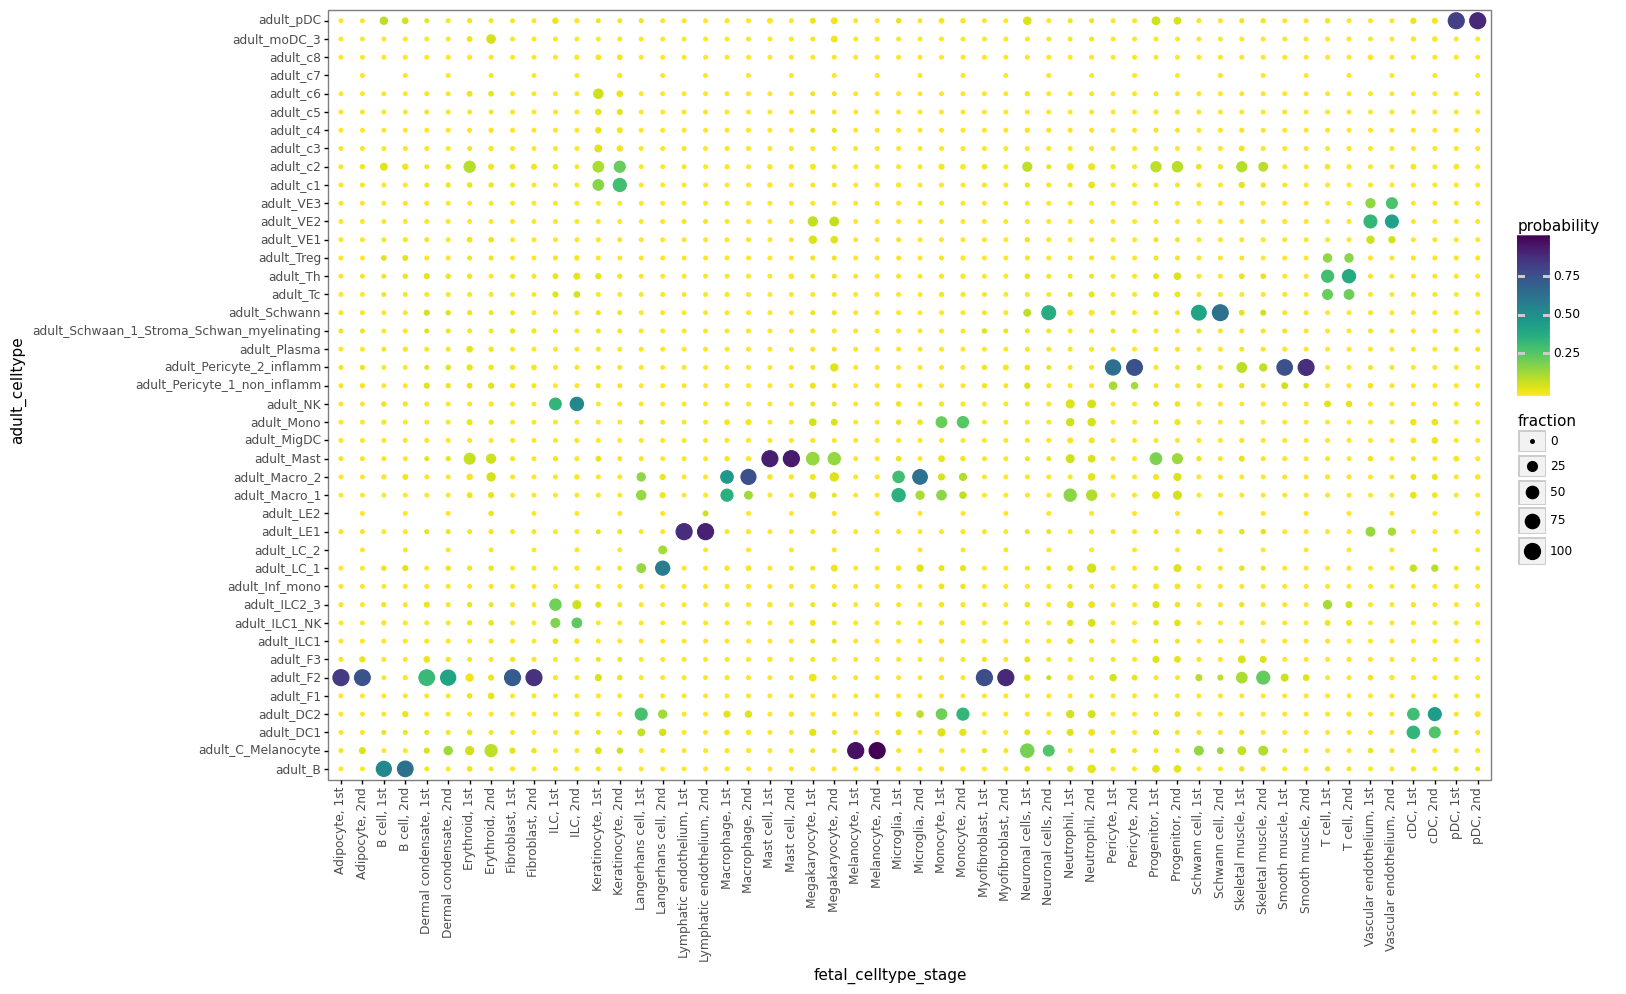

<ggplot: (8730459483667)>

In [182]:
pln.options.figure_size = (15, 10)
(
    ggplot(
        pred_df3,
        aes(y="adult_celltype", x="fetal_celltype_stage", size="fraction", color="probability"),
    )
    + pln.geom_point()
    + pln.scale_color_cmap("viridis_r")
    + pln.theme_bw()
    + pln.theme(axis_text_x=pln.element_text(rotation=90), panel_grid=pln.element_blank())
)

In [144]:
pred_df21 = (
    (
        pred_df2.set_index(["fetal_celltype", "adult_celltype"])
        - pred_df1.set_index(["fetal_celltype", "adult_celltype"])
    )
    .reset_index()
    .fillna(0)
)
pred_df21["abs_fraction"] = np.abs(pred_df21.fraction)

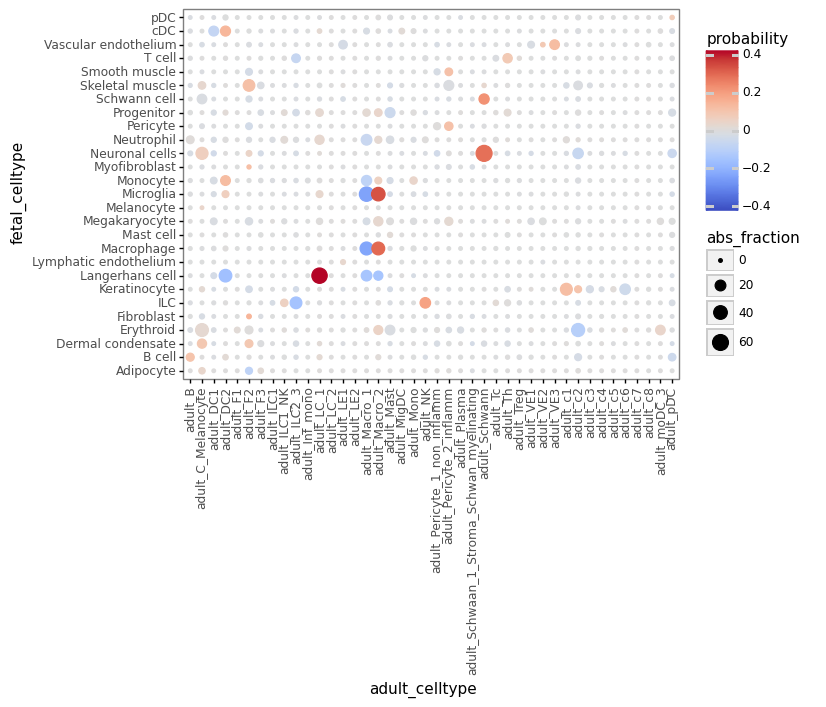

<ggplot: (8730461382199)>

In [148]:
(
    ggplot(
        pred_df21,
        aes(x="adult_celltype", y="fetal_celltype", size="abs_fraction", color="probability"),
    )
    + pln.geom_point()
    + pln.scale_color_cmap("coolwarm", limits=(-0.4, 0.4))
    + pln.theme_bw()
    + pln.theme(axis_text_x=pln.element_text(rotation=90), panel_grid=pln.element_blank())
)

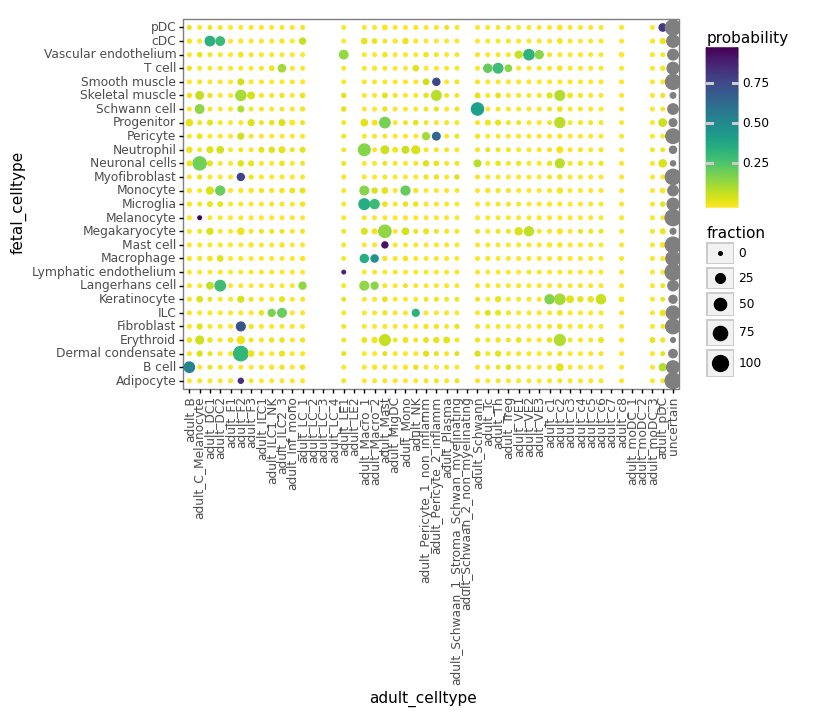

<ggplot: (8730460243086)>

In [168]:
(
    ggplot(
        pred50_df1,
        aes(x="adult_celltype", y="fetal_celltype", size="fraction", color="probability"),
    )
    + pln.geom_point()
    + pln.scale_color_cmap("viridis_r")
    + pln.theme_bw()
    + pln.theme(axis_text_x=pln.element_text(rotation=90), panel_grid=pln.element_blank())
)

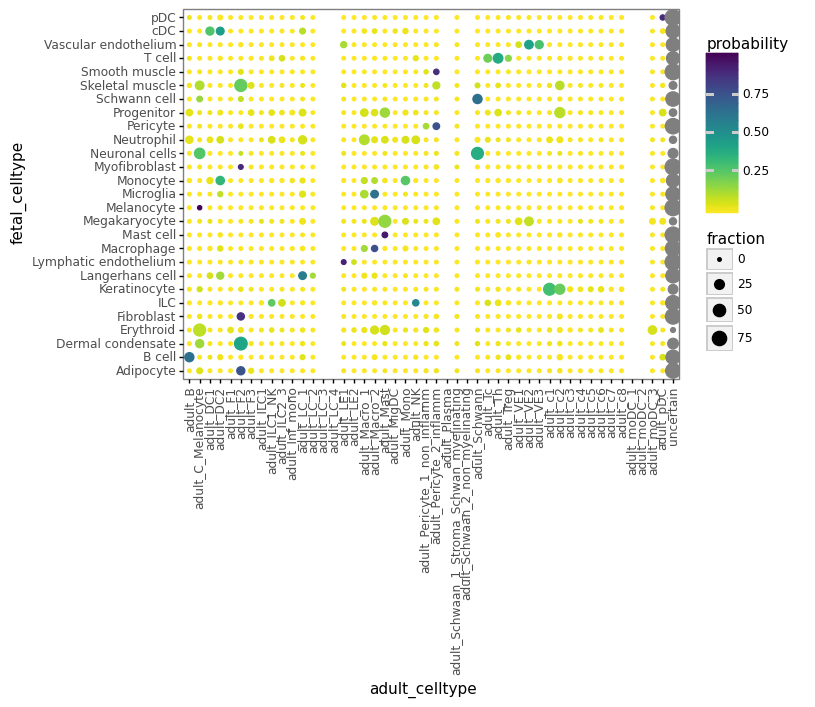

<ggplot: (8730462362450)>

In [118]:
(
    ggplot(
        pred50_df2,
        aes(x="adult_celltype", y="fetal_celltype", size="fraction", color="probability"),
    )
    + pln.geom_point()
    + pln.scale_color_cmap("viridis_r")
    + pln.theme_bw()
    + pln.theme(axis_text_x=pln.element_text(rotation=90), panel_grid=pln.element_blank())
)

In [183]:
pred50_df3 = pd.concat([pred50_df1.assign(stage="1st"), pred50_df2.assign(stage="2nd")]).assign(
    fetal_celltype_stage=lambda x: x.fetal_celltype + ", " + x.stage
)

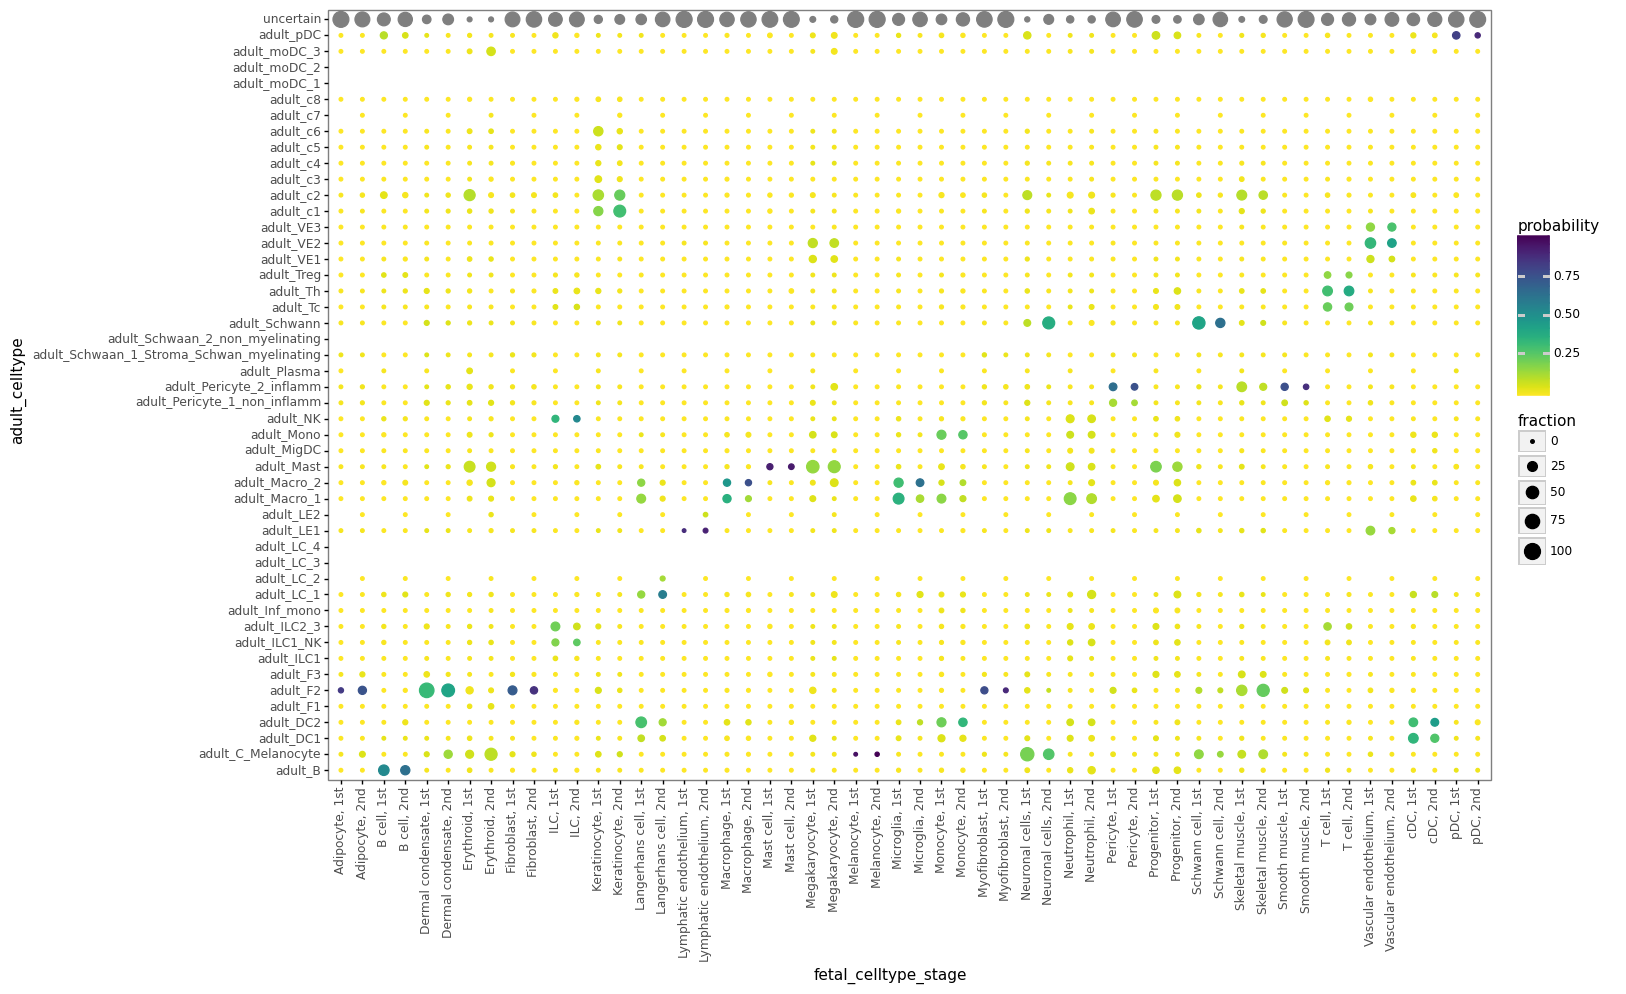

<ggplot: (8730459486859)>

In [184]:
pln.options.figure_size = (15, 10)
(
    ggplot(
        pred50_df3,
        aes(y="adult_celltype", x="fetal_celltype_stage", size="fraction", color="probability"),
    )
    + pln.geom_point()
    + pln.scale_color_cmap("viridis_r")
    + pln.theme_bw()
    + pln.theme(axis_text_x=pln.element_text(rotation=90), panel_grid=pln.element_blank())
)

In [154]:
pred50_df21 = (
    (
        pred50_df2.set_index(["fetal_celltype", "adult_celltype"])
        - pred50_df1.set_index(["fetal_celltype", "adult_celltype"])
    )
    .reset_index()
    .fillna(0)
)
pred50_df21["abs_fraction"] = np.abs(pred50_df21.fraction)

In [166]:
pred50_df21.set_index(["fetal_celltype", "adult_celltype"])["fraction"]

fetal_celltype  adult_celltype    
Adipocyte       adult_B               0.00
                adult_C_Melanocyte    2.90
                adult_DC1             0.00
                adult_DC2             0.00
                adult_F1              0.00
                                      ... 
pDC             adult_moDC_1          0.00
                adult_moDC_2          0.00
                adult_moDC_3          0.00
                adult_pDC            -7.61
                uncertain             7.72
Name: fraction, Length: 1296, dtype: float64

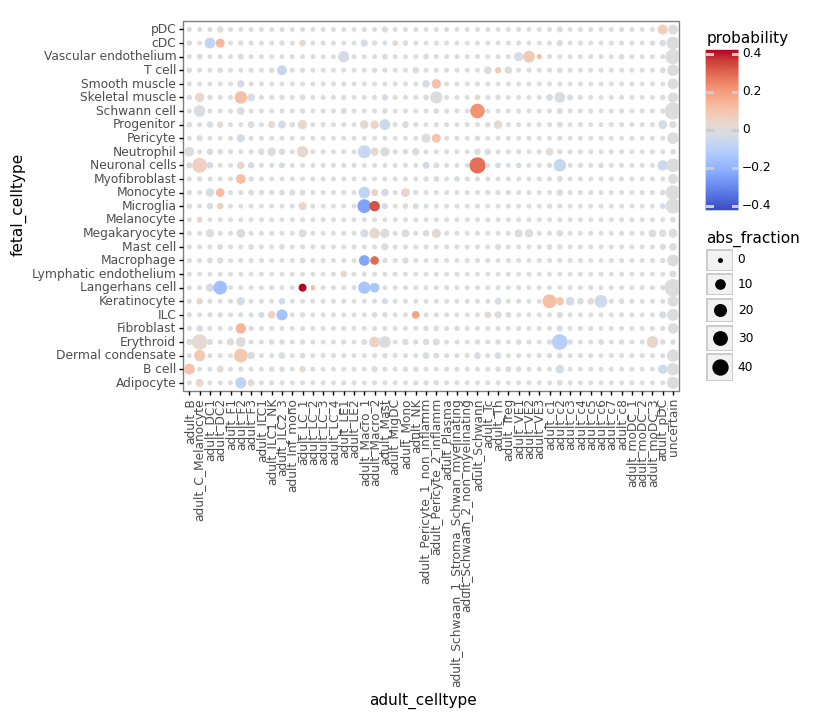

<ggplot: (8730460268270)>

In [164]:
(
    ggplot(
        pred50_df21,
        aes(x="adult_celltype", y="fetal_celltype", size="abs_fraction", color="probability"),
    )
    + pln.geom_point()
    # + pln.scale_color_cmap('coolwarm', limits=(-10, 10), guide=False)
    + pln.scale_color_cmap("coolwarm", limits=(-0.4, 0.4))
    + pln.theme_bw()
    + pln.theme(axis_text_x=pln.element_text(rotation=90), panel_grid=pln.element_blank())
)